In [1]:
#import useful libraries for analysis and modeling
import pandas as pd
import numpy as np
from sklearn import tree
from scipy import stats
import os
import pickle
import sys
import tempfile
import math
# import matplotlib as mpl
# import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.tree import export_graphviz, DecisionTreeClassifier
pd.options.mode.chained_assignment = None
from IPython.display import display, HTML
import warnings
import json
from matplotlib import cm  # color map
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import copy as cp
import shap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, DistanceMetric
from sklearn.preprocessing import scale
from sklearn.datasets import load_iris, load_wine
from matplotlib import pyplot as plt
import colorcet as cc
from sklearn.covariance import EllipticEnvelope 
#
from sklearn.cluster import OPTICS
from sklearn.cluster import DBSCAN
from sklearn.cluster import HDBSCAN
from sklearn.cluster import AgglomerativeClustering
import gower
from scipy.spatial.distance import hamming

# Filter all warnings
warnings.filterwarnings("ignore")

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# classes = ['Dropcam', 'HP Printer', 'Netatmo Welcome', 'Withings Smart Baby Monitor', 'Netatmo weather station',\
#            'Smart Things', 'Amazon Echo', 'Samsung SmartCam','TP-Link Day Night Cloud camera', 'Triby Speaker',\
#               'Belkin Wemo switch', 'TP-Link Smart plug', 'PIX-STAR Photo-frame','Belkin wemo motion sensor',\
#                      'Samsung Galaxy Tab', 'NEST Protect smoke alarm', 'Withings Smart scale', 'IPhone',\
#                             'MacBook', 'Withings Aura smart sleep sensor','Light Bulbs LiFX Smart Bulb',\
#                             'Blipcare Blood Pressure meter','iHome', 'Insteon Camera', 'Android Phone', 'Laptop']
### Least successful classes
classes = ['MacBook', 'HP Printer', 'PIX-STAR Photo-frame', 'Android Phone', 'TP-Link Smart plug', 'TP-Link Day Night Cloud camera',\
        'Dropcam', 'Blipcare Blood Pressure meter', 'IPhone']
# 'Blipcare Blood Pressure meter', 'IPhone'
classes_df = pd.DataFrame(classes, columns=['class'])

# list of all extracted features
feats_all = ["ip.len","ip.ttl","tcp.flags.syn","tcp.flags.ack","tcp.flags.push","tcp.flags.fin","tcp.flags.rst",\
            "tcp.flags.ece","ip.proto","srcport","dstport","ip.hdr_len","tcp.window_size_value","tcp.hdr_len","udp.length",\
            "Min Packet Length","Max Packet Length","Packet Length Mean","Packet Length Total","UDP Len Min","UDP Len Max",\
                "Flow IAT Min","Flow IAT Max","Flow IAT Mean","Flow Duration",\
                    "SYN Flag Count","ACK Flag Count","PSH Flag Count","FIN Flag Count","RST Flag Count","ECE Flag Count"]

# list of easy to compute online features - without means
feats_easy = ["ip.len","ip.ttl","tcp.flags.syn","tcp.flags.ack","tcp.flags.push","tcp.flags.fin","tcp.flags.rst",\
            "tcp.flags.ece","ip.proto","srcport","dstport","ip.hdr_len","tcp.window_size_value","tcp.hdr_len","udp.length",\
            "Min Packet Length","Max Packet Length","Packet Length Total","UDP Len Min","UDP Len Max",\
                "Flow IAT Min","Flow IAT Max","Flow Duration","SYN Flag Count","ACK Flag Count",\
                    "PSH Flag Count","FIN Flag Count","RST Flag Count","ECE Flag Count"]

feats_no_time = ["ip.len","ip.ttl","tcp.flags.syn","tcp.flags.ack","tcp.flags.push","tcp.flags.fin","tcp.flags.rst",\
            "tcp.flags.ece","ip.proto","srcport","dstport","tcp.window_size_value","tcp.hdr_len","udp.length",\
            "Min Packet Length","Max Packet Length","Packet Length Total",\
                "SYN Flag Count","ACK Flag Count","PSH Flag Count","FIN Flag Count","RST Flag Count","ECE Flag Count"]

In [3]:
def convert_str_to_dict(field_value):
    return json.loads(field_value.replace("\'", "\""))

""" Function to save trained model to pickle"""
def save_model(RF, filename):
    pickle.dump(RF, open(filename, 'wb'))

def get_test_labels(IoT_Test):
    array_of_indices = []
    unique_labels = IoT_Test["Label"].unique()
    for lab in unique_labels:
        index = classes_df[classes_df['class'] == lab].index.values[0]
        array_of_indices.append(index)
    return unique_labels, array_of_indices

"""
Function to Fit model based on optimal values of depth and number of estimators and use it
to compute feature importance for all the features.
"""
def get_feature_importance(depth, n_tree, max_leaf, X_train, y_train, weight_of_samples,columns):
    
    # rf_opt = RandomForestClassifier(max_depth = depth, n_estimators = n_tree, max_leaf_nodes=max_leaf, random_state=42, bootstrap=False,n_jobs=10)
    rf_opt = RandomForestClassifier(max_depth = depth, n_estimators = n_tree, random_state=42, bootstrap=False,n_jobs=10)
    rf_opt.fit(X_train, y_train, sample_weight=weight_of_samples)
    feature_importance = pd.DataFrame(rf_opt.feature_importances_)
    # feature_importance.index = X_train.columns
    feature_importance.index = columns
    feature_importance = feature_importance.sort_values(by=list(feature_importance.columns),axis=0,ascending=False)
    
    return feature_importance

"""
Function to Fit model based on optimal values of depth and number of estimators and feature importance
to find the fewest possible features to exceed the previously attained score with all selected features
"""
def get_fewest_features(depth, n_tree, max_leaf, importance):    
    sorted_feature_names = importance.index
    # print('sorted_feature_names: ', sorted_feature_names)
    features = []
    for f in range(1,len(sorted_feature_names)+1):
        features.append(sorted_feature_names[0:f])
    return features

def get_result_scores(classes, cl_report):
    precision=[]
    recall=[]
    f1_score=[]
    supports=[]
    for a_class in classes:
        precision.append(cl_report[a_class]['precision'])
        recall.append(cl_report[a_class]['recall'])
        f1_score.append(cl_report[a_class]['f1-score'])
        supports.append(cl_report[a_class]['support'])
    return precision, recall, f1_score, supports

"""
Function to calculate the score of the model
"""
def get_scores(classes, depth, n_tree, feats, max_leaf, X_train, y_train, X_test, y_test, unique_labels,array_of_indices,weight_of_samples):
    # model = RandomForestClassifier(max_depth=depth, n_estimators = n_tree, max_leaf_nodes=max_leaf, n_jobs=10,
    #                                 random_state=42, bootstrap=False)
    
    model = RandomForestClassifier(max_depth=depth, n_estimators = n_tree, n_jobs=10,
                                    random_state=42, bootstrap=False)
    
    print(model)
    
    model.fit(X_train[feats], y_train, sample_weight=weight_of_samples)
    y_pred = model.predict(X_test[feats])

    y_test = [int(label) for label in y_test.values]
    y_pred = [int(label) for label in y_pred]

    class_report = classification_report(y_test, y_pred, labels=unique_labels, target_names=array_of_indices, output_dict = True)

    macro_score = class_report['macro avg']['f1-score']
    weighted_score = class_report['weighted avg']['f1-score']

    return model, class_report, macro_score, weighted_score, y_pred

def get_model(classes, depth, n_tree, feats, max_leaf, X_train, y_train, X_test, y_test, unique_labels,array_of_indices,weight_of_samples):
    model = RandomForestClassifier(max_depth=depth, n_estimators = n_tree, n_jobs=10,
                                    random_state=42, bootstrap=False)
    
    model.fit(X_train[feats], y_train, sample_weight=weight_of_samples)

    return model

def get_x_y_flow(Dataset, feats):    
    X = Dataset[feats]
    y = Dataset['Label'].replace(classes, range(len(classes)))
    sample_nature = Dataset['sample_nature']
    return X, y, sample_nature

def get_x_y_flow_binary(Dataset, feats):    
    X = Dataset[feats]
    y = Dataset['Label_Binary'].replace(classes, range(len(classes)))
    sample_nature = Dataset['sample_nature']
    return X, y, sample_nature

"""
Function to calculate the score of the model in terms of Flow-Level metric
"""
def expand_rows_and_get_scores(y_true, y_pred, sample_nature, multiply, test_flow_pkt_cnt, test_flow_IDs, unique_labels, array_of_indices):
    expanded_y_true = []
    expanded_y_pred = []
    #
    expanded_weights = []
    expanded_flow_IDs = []
    
    for true_label, pred_label, nature, mult, pkt_cnt, f_id in zip(y_true, y_pred, sample_nature, multiply, test_flow_pkt_cnt, test_flow_IDs):
        if nature == 'flw':
            expanded_y_true.extend([true_label] * (mult+1))
            expanded_y_pred.extend([pred_label] * (mult+1))
            #
            expanded_weights.extend([1/pkt_cnt] * (mult+1))
            expanded_flow_IDs.extend([f_id]* (mult+1))
        else:
            expanded_y_true.append(true_label)
            expanded_y_pred.append(pred_label)
            #
            expanded_weights.append(1/pkt_cnt)
            expanded_flow_IDs.append(f_id)
    
    # report = classification_report(expanded_y_true, expanded_y_pred)
    
    num_samples = len(expanded_y_true)

    expanded_y_true = [int(label) for label in expanded_y_true]
    expanded_y_pred = [int(label) for label in expanded_y_pred]
    # labels=array_of_indices, target_names=unique_labels,
    cl_report_PL = classification_report(expanded_y_true, expanded_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)
    macro_f1_PL = cl_report_PL['macro avg']['f1-score']
    weighted_f1_PL = cl_report_PL['weighted avg']['f1-score']
    try:
        micro_f1_PL = cl_report_PL['micro avg']['f1-score']
    except:
        micro_f1_PL = cl_report_PL['accuracy']
    ####
    
    c_report_FL =  classification_report(expanded_y_true, expanded_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True,sample_weight=expanded_weights)
    
    macro_f1_FL = c_report_FL['macro avg']['f1-score']
    weighted_f1_FL = c_report_FL['weighted avg']['f1-score']
    try:
        micro_f1_FL = c_report_FL['micro avg']['f1-score']
    except:
        micro_f1_FL = c_report_FL['accuracy']
    
    return num_samples, macro_f1_PL, weighted_f1_PL, micro_f1_PL, cl_report_PL, macro_f1_FL, weighted_f1_FL, micro_f1_FL, c_report_FL, expanded_y_true, expanded_y_pred, expanded_weights

def compute_flow_pkt_scores(y_pred, y_test, sample_nature,unique_labels,array_of_indices):

    # Create a data frame with the three columns
    df = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test, 'sample_nature': sample_nature})
    
    # Split the data frame into two data frames based on sample_nature
    pkt_df = df[df['sample_nature'] == 'pkt']
    flw_df = df[df['sample_nature'] == 'flw']
    
    # Compute macro and weighted F1 scores for pkt_df
    pkt_df_y_true = [int(label) for label in pkt_df['y_test'].values]
    pkt_df_y_pred = [int(label) for label in pkt_df['y_pred']]

    # labels=array_of_indices, target_names=unique_labels,
    pkt_macro_f1 = classification_report(pkt_df_y_true, pkt_df_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)['macro avg']['f1-score']
    pkt_weighted_f1 = classification_report(pkt_df_y_true, pkt_df_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)['weighted avg']['f1-score']
    
    # Compute macro and weighted F1 scores for flw_df
    flw_df_y_true = [int(label) for label in flw_df['y_test'].values]
    flw_df_y_pred = [int(label) for label in flw_df['y_pred']]

    flw_macro_f1 = classification_report(flw_df_y_true, flw_df_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)['macro avg']['f1-score']
    flw_weighted_f1 = classification_report(flw_df_y_true, flw_df_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)['weighted avg']['f1-score']

    return pkt_macro_f1, pkt_weighted_f1, flw_macro_f1, flw_weighted_f1

In [4]:
# Define a function to check the conditions and assign values
def assign_sample_nature(row):
    if (row["Min Packet Length"] == -1 and
        row["Max Packet Length"] == -1 and
        row["Flow IAT Min"] == -1 and
        row["Flow IAT Max"] == -1):
        return "pkt"
    else:
        return "flw"

In [5]:
def read_csv(csv_file_names):
    csv_files = []
    for f_name in csv_file_names:
        df = pd.read_csv(f_name, sep=';')
        csv_files.append(df)
        
    return pd.concat(csv_files)

In [6]:
def plot_line(x_axis_values, y_axis_values, labels, x_title, y_title, fig_title):
    fig = plt.figure(figsize = (15, 5))
    colors= {'#6E7E99', '#ffbb78','#8A9961','#1f77b4', '#E06B5A', '#A95C68'}
    # for x_axis_val, y_axis_val, label, color in zip(x_axis_values, y_axis_values, labels, colors):
    #     plt.plot(x_axis_val, y_axis_val, label=label, color=color, linewidth=1.5)
    
    for x_axis_val, y_axis_val, color in zip(x_axis_values, y_axis_values, colors):
        plt.plot(x_axis_val, y_axis_val, 'g*-', color=color, linewidth=1.5, markersize=4)
    plt.plot(x_axis_val, [0.7 for i in range(0, len(x_axis_val))], color='gray', linestyle='--', lw=1)
    plt.plot(x_axis_val, [0.5 for i in range(0, len(x_axis_val))], color='gray', linestyle='--', lw=1)
    plt.xlabel(x_title, fontsize=15, labelpad=13)
    plt.ylabel(y_title, fontsize=15, labelpad=14)
    plt.xticks(rotation=90)
    plt.title(fig_title)
    plt.legend()
    plt.show()

In [7]:
#### PCFI - Per Class Feature Importance ####
def f_gini(v):
    p = v/v.sum()
    return np.multiply(p, 1-p).sum()

def f_entropy(v):
    return sps.entropy(pk=v)

def f_misclassification(v):
    p = v/v.sum()
    
def calcImportanceMatrix(rf_clf):
    """
    Calculates the importance matrix of predictors for each class.

    Arguments:
        rf_clf - The random forest classifier to calculate the importance matrix for.
        Must (?) be a RandomForestClassifier object. EXTENSIBLE TO ANY DECISION TREE CLASSIFIER FROM sklearn.tree?

    Returns:
        importance_matrix - The importance matrix with the importance of each predictor in predicting a class.
        A n by m numpy array.

    """

    # get the number of classes being predicted by the random forest
    classes = rf_clf.classes_
    n_classes = len(classes)

    # init storage for the predictor importances by classes by trees
    importance_matrix = []

    #dec_tree = rf_clf.estimators_[0]
    for dec_tree in rf_clf.estimators_:

        # get the criterion used to measure impurity
        criterion = dec_tree.get_params()['criterion']
        if criterion == 'gini':
            f_impurity = f_gini
        elif criterion == 'entropy':
            f_impurity = f_entropy
        elif criterion == 'misclassification':
            f_impurity = f_misclassification
        else:
            f_impurity = 0
            print('Unassigned impurity measure')

        # get the number of features and nodes in the tree
        feature = dec_tree.tree_.feature
        n_features = dec_tree.tree_.n_features
        n_nodes = dec_tree.tree_.__getstate__()['node_count']
        nodes = dec_tree.tree_.__getstate__()['nodes']
        parent_node_ind = -np.ones(shape=n_nodes, dtype='<i8')
        #parent_node_ind[0] = n_nodes + 1
        #print(parent_node_ind)
        for par_ind,node in enumerate(nodes):
            if node[0] != -1:
                parent_node_ind[node[0]] = par_ind
            if node[1] != -1:
                parent_node_ind[node[1]] = par_ind
        #print(parent_node_ind)

        # identify the leaves of the tree
        is_leaves = np.array([node[0]==-1 and node[1]==-1 for node in nodes])
        
        leaves_index = np.nonzero(is_leaves)[0]

        values_sorted = dec_tree.tree_.__getstate__()['values']
        #print ('nodes', nodes, len(nodes), len(values_sorted[:,0,:]))
        node_pred = np.argmax(values_sorted[:,0,:], axis=1)
        # print('NODE PRED:', node_pred)
        leaves_class_index = node_pred[is_leaves]
        #for par_ind,node in enumerate(nodes):
        #    print(par_ind,parent_node_ind[par_ind],is_leaves[par_ind],node,
        #          values_sorted[par_ind], values_sorted[par_ind].sum())
        node_unvisited = np.ones((n_classes, n_nodes), dtype=bool)
        tree_importances = np.zeros((n_classes, n_features))
        for leaf_i,leaf_c_i in zip(leaves_index,leaves_class_index):
            current_i = parent_node_ind[leaf_i]
            # print('START from leaf ', leaf_i, 'with class ', leaf_c_i)
            #print('whose parent is ', current_i)
            # walk the tree and calculate the importance of the predictor
            while current_i != -1 and node_unvisited[leaf_c_i,current_i]:
                current_node = nodes[current_i]
                left_node = nodes[current_node['left_child']]
                right_node = nodes[current_node['right_child']]
                current_feature = current_node['feature']
                
                current_values = values_sorted[current_i,0,:]
                left_values = values_sorted[current_node['left_child'],0,:]
                right_values = values_sorted[current_node['right_child'],0,:]
                
                # print(leaves_class_index, current_values_class)
                current_values_class = np.array([
                    current_values[leaf_c_i],
                    current_values[np.arange(len(current_values)) != leaf_c_i].sum()
                ])
                left_values_class = np.array([
                    left_values[leaf_c_i],
                    left_values[np.arange(len(left_values)) != leaf_c_i].sum()
                ])
                right_values_class = np.array([
                    right_values[leaf_c_i],
                    right_values[np.arange(len(right_values)) != leaf_c_i].sum()
                ])
                tree_importances[leaf_c_i,current_feature] += (
                        current_node['weighted_n_node_samples'] * f_impurity(current_values_class) -
                        left_node['weighted_n_node_samples'] * f_impurity(left_values_class) -
                        right_node['weighted_n_node_samples'] * f_impurity(right_values_class)
                        )
                ###
                node_unvisited[leaf_c_i,current_i] = False
                current_i = parent_node_ind[current_i]
                #print('next current is ', current_i)
        # print(tree_importances.shape)
        importance_matrix.append(tree_importances/nodes[0]['weighted_n_node_samples'])
        # print(importance_matrix)

    # average the predictor importances for each class by all of the trees in the forest
    importance_matrix = np.mean(importance_matrix, axis = 0)
    #normalise importance over each class
    importance_matrix = (importance_matrix.T / np.sum(importance_matrix, axis=1)).T
    return(importance_matrix)

## WITHOUT LIMITATION

#### N=2 RF(16, 4,13) - Generate the chosen model

In [8]:
# Load Train and Test data
time = "normal"
npkts = 2
feats_to_use = feats_all
if(time=="normal"):
    train_data = pd.read_csv("/home/nds-admin/UNSW_PCAPS/train/train_data_hybrid/train_data_"+str(npkts)+".csv")
    test_data = pd.read_csv("/home/nds-admin/UNSW_PCAPS/test/csv_files/16-10-05.pcap.txt_"+str(npkts)+"_pkts.csv")
###########
flow_pkt_counts = pd.read_csv("/home/nds-admin/UNSW_PCAPS/hyb_code/16-10-05-flow-counts.csv")
#
flow_count_dict = flow_pkt_counts.set_index("flow.id")["count"].to_dict()
# Map the values from flow_pkt_counts to test_data based on the "Flow ID" column
test_data["pkt_count"] = test_data["Flow ID"].map(flow_count_dict)

###########
#### To get packet count of each flow in train data
packet_data = pd.read_csv("/home/nds-admin/UNSW_PCAPS/train/train_data_hybrid/UNSW_train_ALL_PKT_DATE.csv")
packet_data = packet_data[['Flow ID', 'packet_count', 'File']]
packet_data['File_ID'] = packet_data['Flow ID'] + ' ' + packet_data['File']
packet_data = packet_data.drop_duplicates(subset='File_ID', keep='first')
train_data['File_ID'] = train_data['Flow ID'] + ' ' + train_data['File']

flow_count_dict_train = packet_data.set_index("File_ID")["packet_count"].to_dict()
# Map the values from flow_pkt_counts to test_data based on the "Flow ID" column
train_data["pkt_count"] = train_data["File_ID"].map(flow_count_dict_train)
###########

######## KEEP ONLY the CLASSES SPECIFIED ###########
train_data = train_data[train_data['Label'].isin(classes)]
test_data = test_data[test_data['Label'].isin(classes)]
####################################################

print(train_data['Label'].unique())
print(test_data['Label'].unique())
##

all_minus_one = (test_data['Min Packet Length'] == -1) & (test_data['Max Packet Length'] == -1) & (test_data['Packet Length Mean'] == -1)

# Assign values to the multiply column based on the conditions
test_data['multiply'] = np.where(all_minus_one, 1, test_data['pkt_count'] - npkts)
#
train_data = train_data.sample(frac=1, random_state=42)
test_data  = test_data.sample(frac=1, random_state=42)
#
train_data = train_data.dropna(subset=['srcport', 'dstport']) 
test_data  = test_data.dropna(subset=['srcport', 'dstport'])
#
test_labels, test_indices = get_test_labels(test_data)
print("Num Labels: ", len(test_labels))
#
train_data['sample_nature'] = train_data.apply(assign_sample_nature, axis=1)
test_data['sample_nature']  = test_data.apply(assign_sample_nature, axis=1)
#
train_data['weight'] = np.where(train_data['sample_nature'] == 'flw', (train_data['pkt_count'] - npkts + 1)/train_data['pkt_count'], 1/train_data['pkt_count'])
weight_of_samples = list(train_data['weight'])

# Get Variables and Labels
y_multiply = test_data['multiply'].astype(int)
test_flow_pkt_cnt = test_data['pkt_count'].to_list()
test_flow_IDs = test_data['Flow ID'].to_list()
X_train, y_train, sample_nat_train = get_x_y_flow(train_data, feats_to_use)
X_test,  y_test, sample_nat_test  = get_x_y_flow(test_data, feats_to_use)
#
test_data['weight'] = np.where(test_data['sample_nature'] == 'flw', (test_data['pkt_count'] - npkts + 1)/test_data['pkt_count'], 1/test_data['pkt_count'])
weight_of_samples_test = list(test_data['weight'])

['Dropcam' 'HP Printer' 'Android Phone' 'MacBook'
 'TP-Link Day Night Cloud camera' 'TP-Link Smart plug'
 'PIX-STAR Photo-frame' 'Blipcare Blood Pressure meter' 'IPhone']
['Dropcam' 'TP-Link Day Night Cloud camera' 'HP Printer'
 'TP-Link Smart plug' 'PIX-STAR Photo-frame' 'MacBook' 'Android Phone']
Num Labels:  7


In [9]:
## The model (the best) chosen for analysis
depth = 16
n_tree = 4
no_feats = 13
leaf = 500 ## not using it
# feats = model_analysis_N3_BEST[(model_analysis_N3_BEST['depth'] == depth) & (model_analysis_N3_BEST['tree'] == n_tree) & (model_analysis_N3_BEST['no_feats'] == no_feats)]['feats'].to_list()[0].strip('[]').strip('\"\'\"').split('\', \'') 
feats = ['srcport', 'dstport', 'ip.len', 'udp.length', 'tcp.hdr_len', 'ip.ttl', 'tcp.window_size_value', 'Max Packet Length', 'Flow IAT Mean', 'Packet Length Mean', 'Flow Duration', 'Flow IAT Max', 'Packet Length Total']
#
model, c_report, macro_f1, weight_f1, y_pred = get_scores(classes, depth, n_tree, feats, leaf, X_train, y_train, X_test, y_test,  test_indices, test_labels, weight_of_samples)
num_samples, macro_f1_PL, weighted_f1_PL, micro_f1_PL, cl_report_PL, macro_f1_FL, weighted_f1_FL, micro_f1_FL, cl_report_FL, expanded_y_true, expanded_y_pred, expanded_weights = expand_rows_and_get_scores(y_test, y_pred, sample_nat_test, y_multiply, test_flow_pkt_cnt, test_flow_IDs, test_indices, test_labels)                       
print(macro_f1_FL, weighted_f1_FL, micro_f1_FL)


RandomForestClassifier(bootstrap=False, max_depth=16, n_estimators=4, n_jobs=10,
                       random_state=42)
0.7765515509447792 0.884110201606972 0.8793044740477223


[Text(0, 0, 'MacBook'),
 Text(1, 0, 'HP Printer'),
 Text(2, 0, 'PIX-STAR Photo-frame'),
 Text(3, 0, 'Android Phone'),
 Text(4, 0, 'TP-Link Smart plug'),
 Text(5, 0, 'TP-Link Day Night Cloud camera'),
 Text(6, 0, 'Dropcam'),
 Text(7, 0, 'Blipcare Blood Pressure meter'),
 Text(8, 0, 'IPhone')]

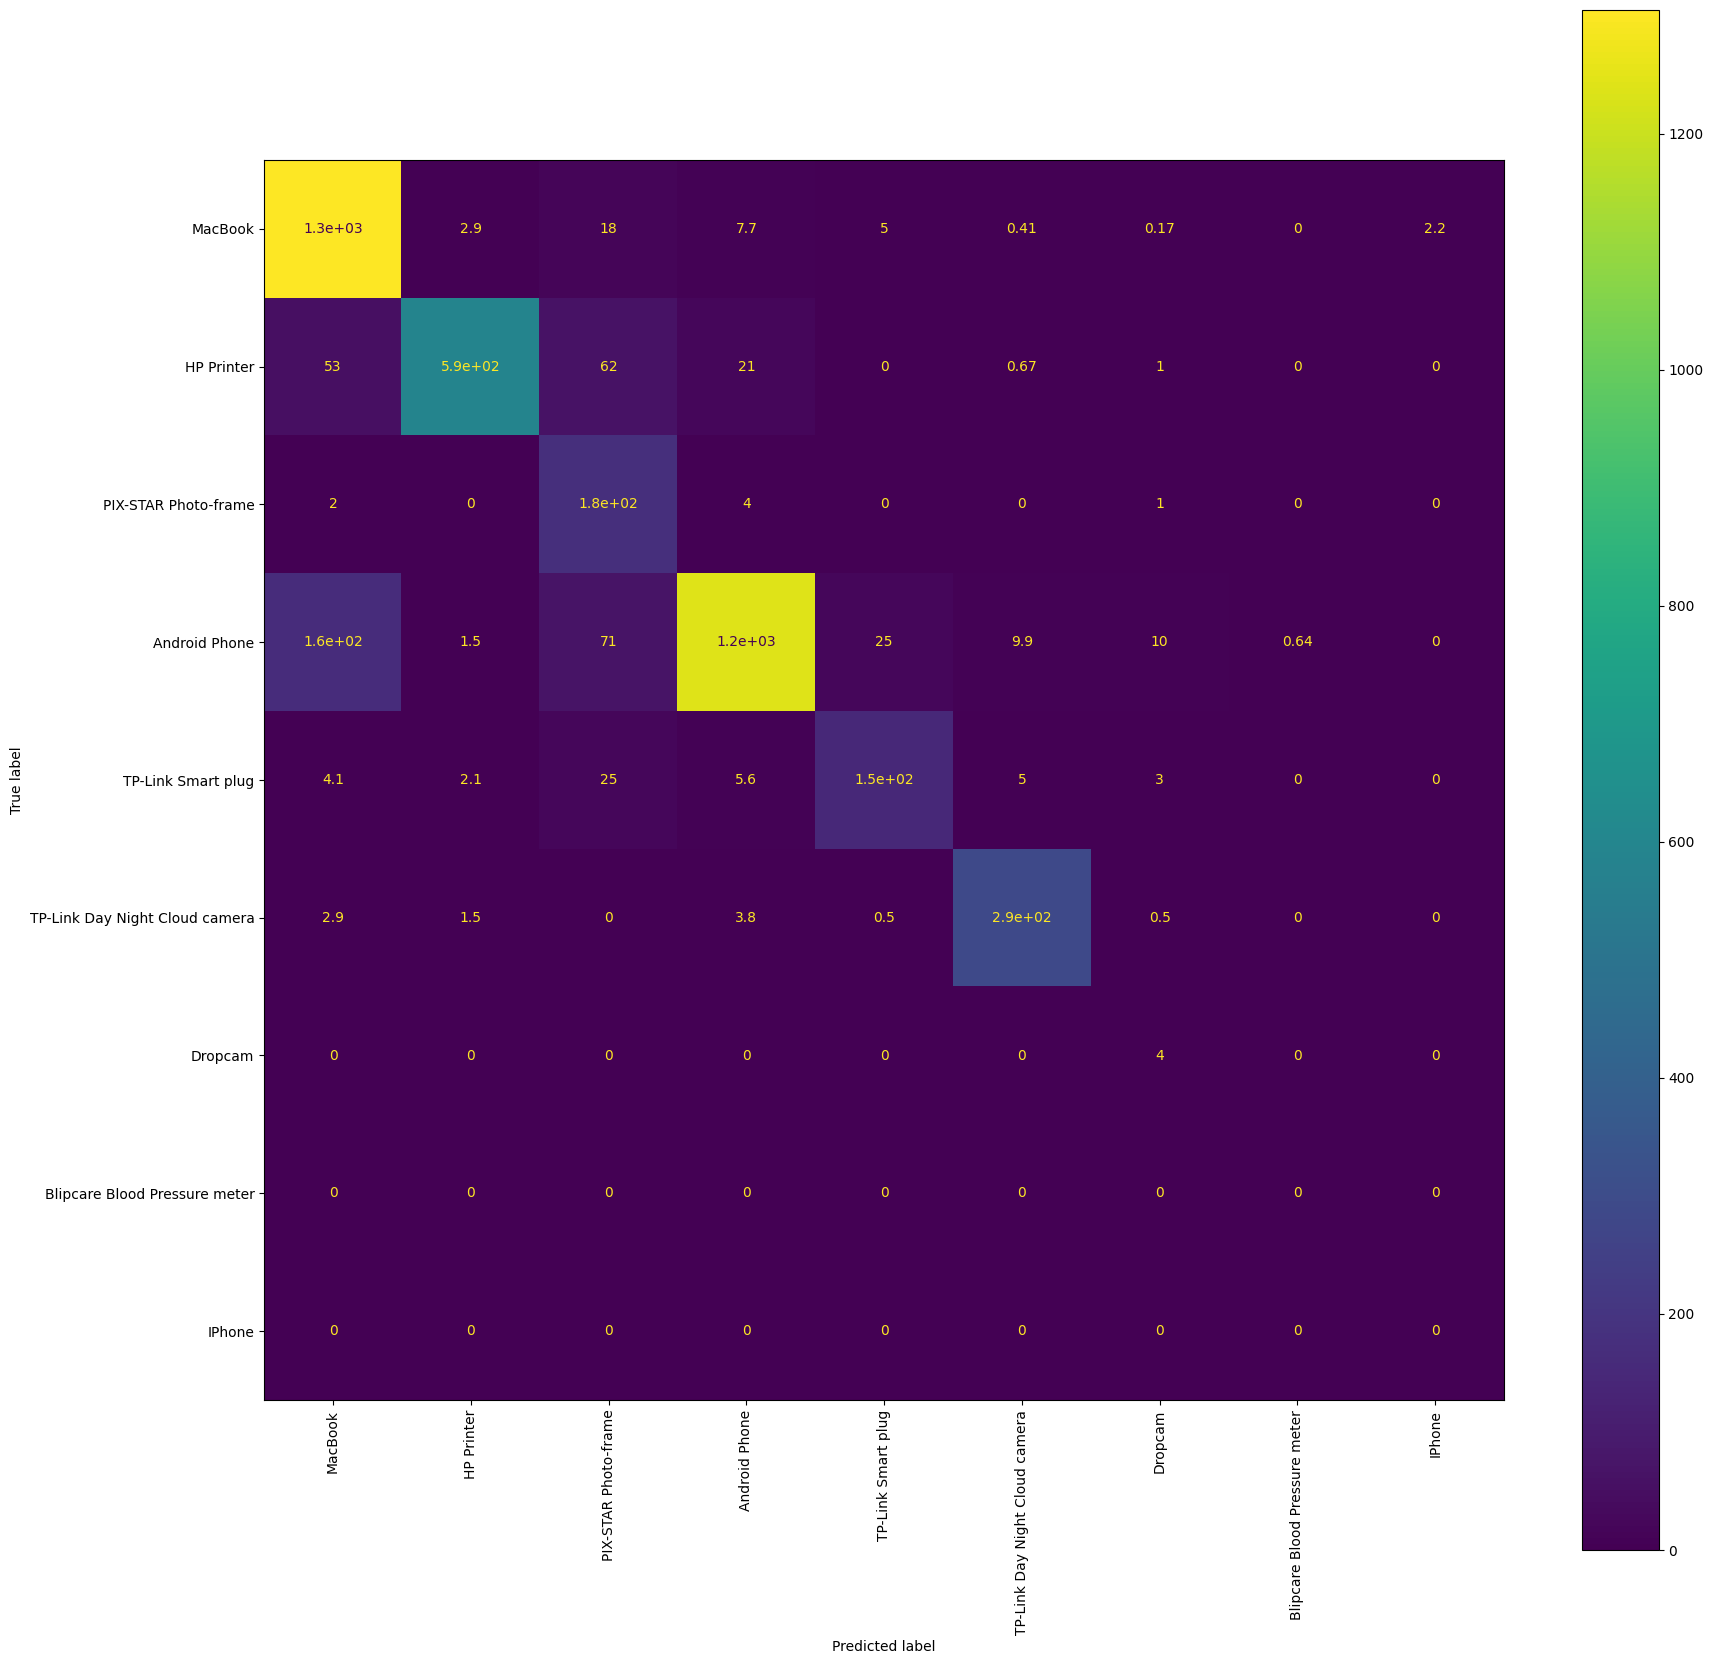

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true=list(expanded_y_true), y_pred=expanded_y_pred, sample_weight=expanded_weights, labels=list(range(0, len(classes))))
#
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(20,20))
disp.plot(ax=ax)
ax.set_xticklabels(classes, rotation=90)

[Text(0, 0, 'MacBook'),
 Text(1, 0, 'HP Printer'),
 Text(2, 0, 'PIX-STAR Photo-frame'),
 Text(3, 0, 'Android Phone'),
 Text(4, 0, 'TP-Link Smart plug'),
 Text(5, 0, 'TP-Link Day Night Cloud camera'),
 Text(6, 0, 'Dropcam'),
 Text(7, 0, 'Blipcare Blood Pressure meter'),
 Text(8, 0, 'IPhone')]

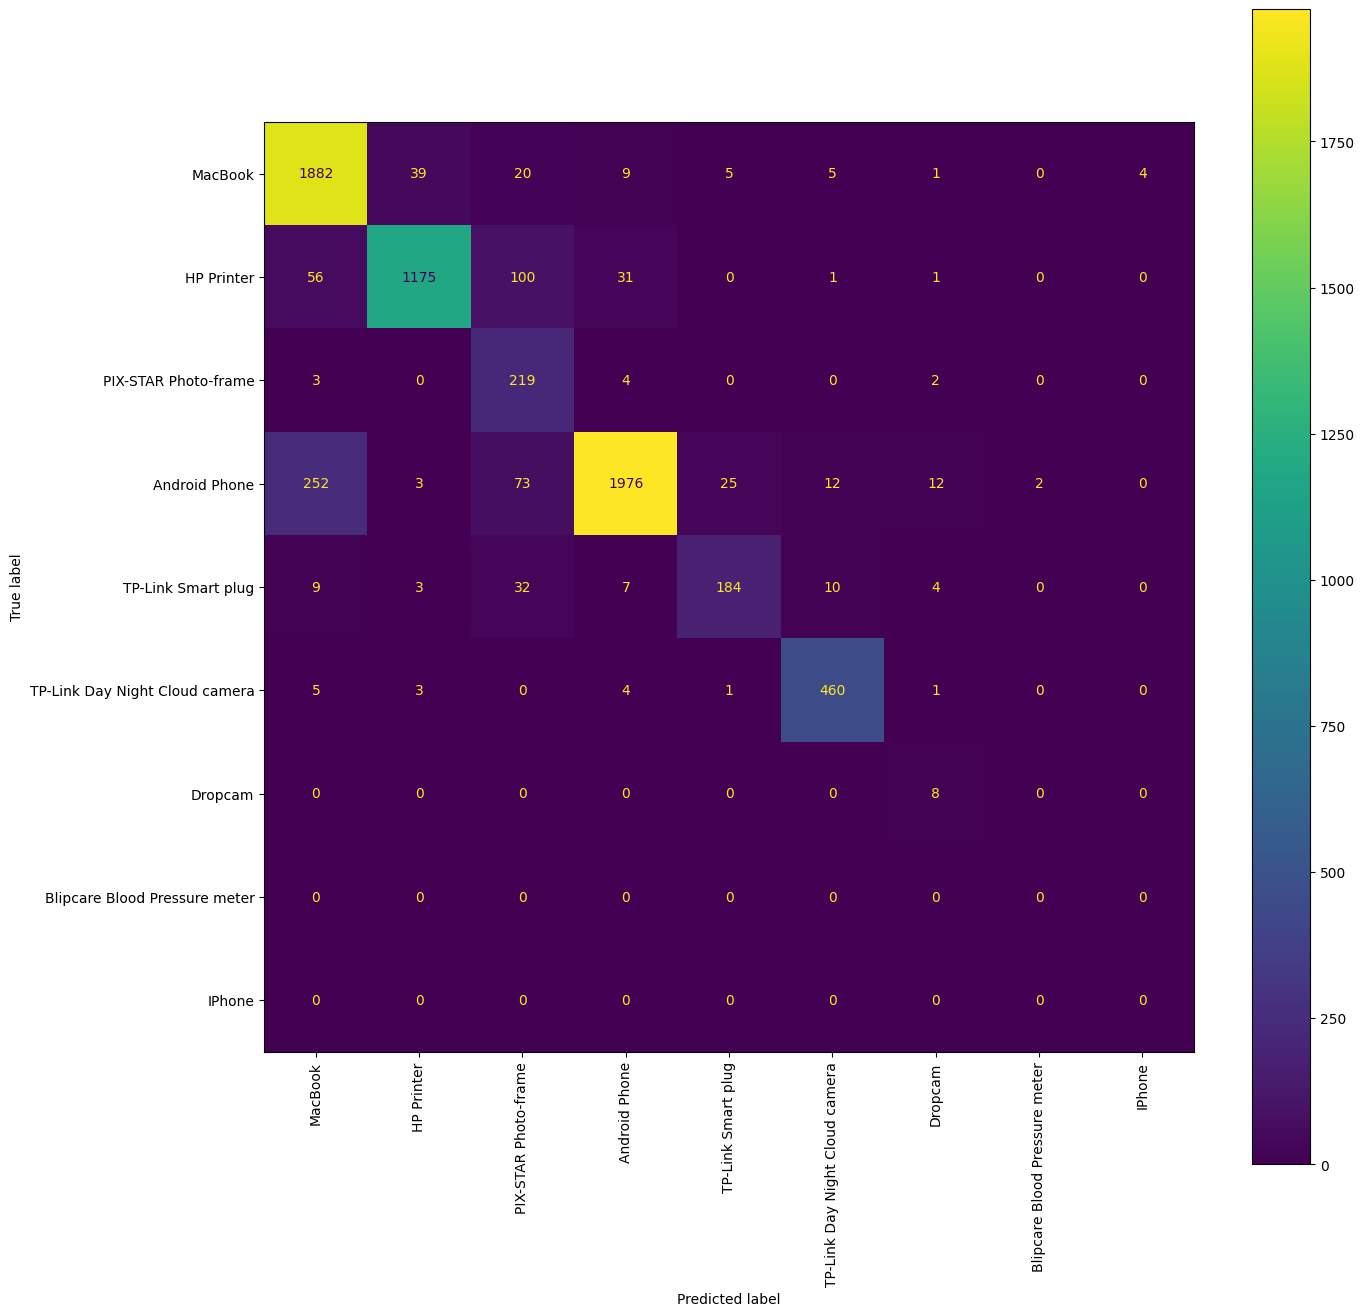

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true=list(y_test), y_pred=y_pred, labels=list(range(0, len(classes))))
#
cm_normalized = []
for cl_list in cm:
    if np.sum(cl_list)!=0:
        cm_normalized.append(np.array(cl_list)*100/np.sum(cl_list))
    else:
        cm_normalized.append(np.array(cl_list))
cm_normalized = np.array(cm_normalized)
# cm_normalized
#
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(15, 15))
disp.plot(ax=ax)
ax.set_xticklabels(classes, rotation=90)

#### Order classes in terms of its scores and PLOT F1-score Per Class

In [10]:
class_names = cl_report_FL.keys()
score_per_class = []
classes_ = []
support_values = []

for c_name in class_names:
    if c_name in classes:
        score_per_class.append(cl_report_FL[c_name]['f1-score'])
        classes_.append(c_name)
        support_values.append(cl_report_FL[c_name]['support'])

classes_.append('IPhone')
score_per_class.append(0)
support_values.append(0)
classes_.append('Blipcare Blood Pressure meter')
score_per_class.append(0.001)
support_values.append(0)
score_per_class_df = pd.DataFrame({'class': classes_, 'f1_score': score_per_class, 'support_values': support_values})
score_per_class_df = score_per_class_df.sort_values(by='f1_score', ascending=False)

In [11]:
# score_per_class_df.to_csv('big_model_exl_classes.csv')

In [12]:
score_per_class_df

,class,f1_score,support_values
0,TP-Link Day Night Cloud camera,0.957810,295.0
3,MacBook,0.908624,1341.0
2,HP Printer,0.890840,727.0
1,Android Phone,0.884492,1525.0
5,TP-Link Smart plug,0.798394,194.0
4,PIX-STAR Photo-frame,0.659825,184.0
6,Dropcam,0.335875,4.0
8,Blipcare Blood Pressure meter,0.001000,0.0
7,IPhone,0.000000,0.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


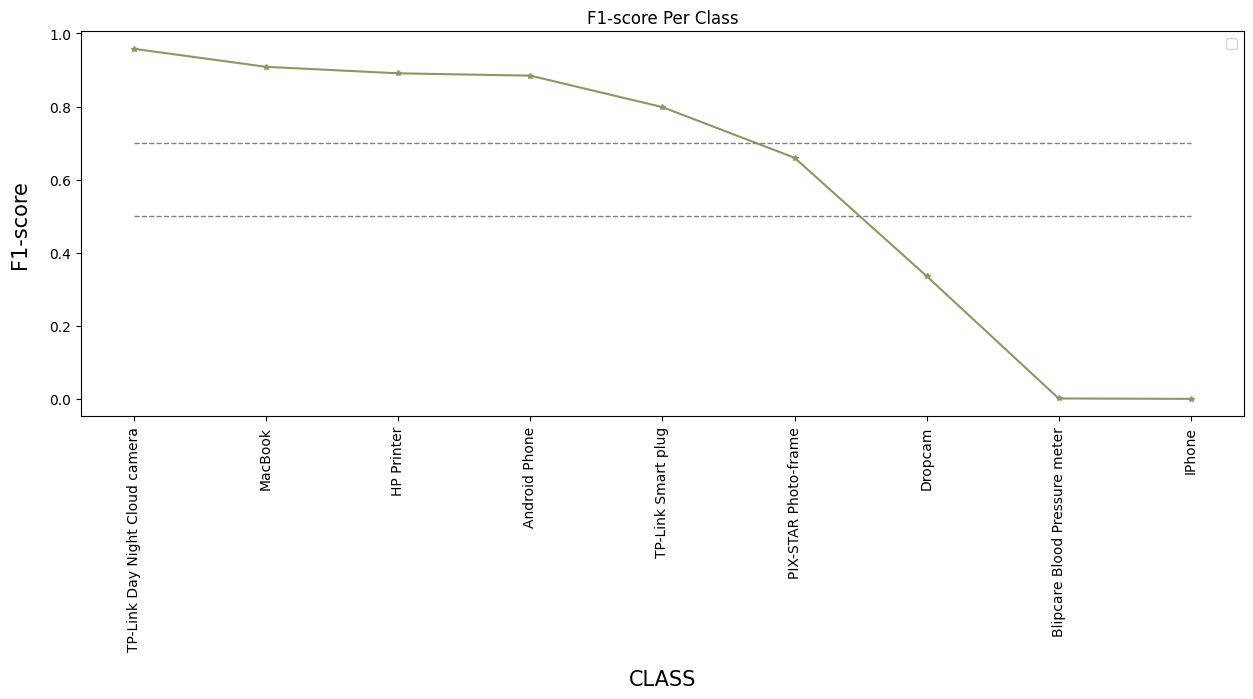

In [13]:
##### TEST
plot_line([score_per_class_df['class'].to_list()], [score_per_class_df['f1_score'].to_list()], [], 'CLASS', 'F1-score', 'F1-score Per Class')

# PCFI
#### Obtaining per-class feature importance

In [14]:
rf_opt = RandomForestClassifier(max_depth = depth, n_estimators = n_tree, random_state=42, bootstrap=False,n_jobs=10)
rf_opt.fit(X_train[feats], y_train, sample_weight=weight_of_samples)

RandomForestClassifier(bootstrap=False, max_depth=16, n_estimators=4, n_jobs=10,
                       random_state=42)

In [15]:
### Matrix containing feature importances per feature-class pair
imp_mat = calcImportanceMatrix(rf_opt)

In [16]:
#### GET ordered classes and GET their features and feature importances in that order
imp_mat_ordered = []
score_per_class_df['f1_score'] = score_per_class_df['f1_score']*100
classes_ordered = score_per_class_df['class'].to_list()
class_scores_ordered = score_per_class_df['f1_score'].to_list()

for cl in classes_ordered:
    ind_of_class = classes.index(cl)
    imp_mat_ordered.append(imp_mat[ind_of_class])
    
## 2 classes which are not in TEST SET
# classes_ordered.append('IPhone')
# class_scores_ordered.append(0)
# imp_mat_ordered.append(imp_mat[classes.index('IPhone')])
# classes_ordered.append('Blipcare Blood Pressure meter')
# class_scores_ordered.append(1)
# imp_mat_ordered.append(imp_mat[classes.index('Blipcare Blood Pressure meter')])

In [17]:
len(classes_ordered)

9

In [18]:
feature_names = feats

# Outlier Detection

## Generate the data and detect outliers
#### With Plots

In [19]:
def take_derivative(class_name, data_dict, threshold):

    imp_list = data_dict[class_name]
    # print(imp_list)
    # Example CDF data
    x = np.arange(len(imp_list))
    y = imp_list

    # print(len(x))
    # print(len(y))

    # Compute the derivative
    dy_dx = np.gradient(y, x)
    print(dy_dx)
    selected_point_index = len(imp_list)-1
    selected_point = dy_dx[selected_point_index]
    for p_dvt in dy_dx:
        if p_dvt < threshold:
            if np.where(dy_dx == p_dvt)[0] < selected_point_index:
                selected_point_index = np.where(dy_dx == p_dvt)[0]
                selected_point = dy_dx[selected_point_index]
    print(selected_point, selected_point_index)
    #
    # Plot the CDF and its derivative
    plt.figure()
    
    plt.scatter(selected_point_index, imp_list[selected_point_index[0] ], color='red', s=45)
    plt.scatter(selected_point_index, dy_dx[selected_point_index[0] ], color='red', s=45)
    plt.plot(x, y, label='Cumulative Importance')
    plt.plot(x, dy_dx, label='Derivative of Cumulative Importance: ' + str(class_name))
    plt.xlabel('Classes')
    plt.ylabel('Importance')
    plt.legend()
    plt.grid(True)
    plt.show()

In [20]:
max_exponent = 709
x_scores = []
y_importances = []
c_name = []
f_name = []
exp_values = []
normal_importances = []
for c in range(0, len(classes_ordered)):
    sum_exp_values = 0
    exp_values_per_class = []
    for f in range(0, len(feature_names)):
        c_name.append(classes_ordered[c])
        f_name.append(feature_names[f])
        x_scores.append(class_scores_ordered[c]/100)
        normal_importances.append(np.array(imp_mat_ordered)[c,f])
        try:
            if(np.array(imp_mat_ordered)[c,f] == 0):
                ### If the values is too big for math.exp
                y_importances.append(max_exponent)
                # print('first set')
            else:
                y_importances.append((1/(np.array(imp_mat_ordered)[c,f]*100)))
            exp_values.append(math.exp(y_importances[-1]))
        except:
            ### If the y_importance values is too big for math.exp
            y_importances[-1] = max_exponent
            exp_values.append(math.exp(y_importances[-1]))
            
# density_df = pd.DataFrame({'c_name': c_name, 'f_name': f_name, 'x_scores': x_scores, 'y_importances': y_importances, 'exp_values': exp_values, 'normalized_exp': normalized_exp_values,  'density': density})
# density_df = pd.DataFrame({'c_name': c_name, 'f_name': f_name, 'x_scores': x_scores, 'normal_importances': normal_importances, 'y_importances': y_importances, 'exp_values': exp_values, 'log10_based_exp': log10_based,'normalized_exp': normalized_exp_values, 'sum_of_importances_log10':sum_of_importances_log10, 'inverse_exp': inverse_exp})
density_df = pd.DataFrame({'c_name': c_name, 'f_name': f_name, 'x_scores': x_scores, 'normal_importances': normal_importances, 'y_importances': y_importances, 'exp_values': exp_values})


density_df['FINAL'] = density_df['exp_values']/(density_df['normal_importances'])
density_df['normal_importances_100'] = density_df['normal_importances']*100
density_df['Feature'] = density_df['f_name'].replace(feature_names, range(len(feature_names)))
        

In [21]:
# density_df[['c_name', 'f_name', 'normal_importances']].to_csv('results_models/density_df_big_model_exlClasses.csv')

In [22]:
prop_increase_dict = {}
cum_increase_dict = {}

In [23]:
### RELATIVE rate of change
def flag_outliers(df, col_name='normal_importances', th=0.5):
    df = df.assign(outlier=True)
    df = df.reset_index()
    df['ccum_sum'] = np.cumsum(np.clip(df[col_name].to_numpy(),0.01,1)[::-1])[::-1]
    cutoff = []
    last_y = df.loc[1]['ccum_sum']
    # print(df['c_name'].unique()[0])
    # print('last_y', last_y)
    last_decrease = df.loc[0]['ccum_sum']-df.loc[1]['ccum_sum']
    # print('last decrease', last_decrease)
    decreases = [last_decrease]
    rel_decrease = [1]
    for index,row in df[2:].iterrows():
        curr_decrease = last_y - row['ccum_sum']
        # print('curr_decrease', curr_decrease)
        decreases.append(curr_decrease)
        rel_improvement =  last_decrease / curr_decrease
        rel_decrease.append(rel_improvement)
        if rel_improvement < th:
            cutoff.append(index)
        last_y = row['ccum_sum']
        last_decrease = curr_decrease
    # # PLOT
    f, ax1 = plt.subplots()
    ax1.plot(decreases, color='C0', label='decreases')
    ax2 = ax1.twinx()
    ax2.plot(rel_decrease, color='C1', label='rel_decreases')
    ax1.set_title(df['c_name'].unique()[0])
    plt.legend()
    plt.show()
    if not cutoff:
        cutoff.append(index)
    print(f'found cutoff: {cutoff[0]}!')
    df['outlier'].iloc[[i for i in range(cutoff[0])]]=False
#     raise Exception
    return df.set_index('index', drop=True)

In [24]:
### RELATIVE rate of change
def flag_outliers_with_cost(df, col_name='normal_importances', th=0.5):
    df = df.assign(outlier=True)
    df = df.reset_index()
    # df['ccum_sum'] = np.cumsum(np.clip(df[col_name].to_numpy(),0.01,1)[::-1])[::-1]
    df['ccum_sum'] = np.cumsum(np.clip(df[col_name].to_numpy(),0.01,1))
    cutoff = []
    last_y = df.loc[1]['ccum_sum']
    # print(df)
    print(df['c_name'].unique()[0])
    cost_values = [i/15 for i in range(1, 16)]
    total_gain_list = []
    ##
    for index,row in df.iterrows():
        ##
        print('Feature NO: ', index, 'Total COST: ', cost_values[index], 'Total GAIN: ', row['ccum_sum'], 'DIFF: ', row['ccum_sum'] - cost_values[index])
        # print('Feature NO: ', count_feat, 'UI    :', math.log(row['ccum_sum']) - math.log(count_feat/(15)))
        ### First Option
        total_gain =  row['ccum_sum'] - cost_values[index]
        ###
        ### Second Option
        # rel_improvement_cost = 0.45*rel_improvement - 0.55*(count_feat)/(15)
        ###
        ### Third Option
        # rel_improvement_cost = rel_improvement - 1.2*(count_feat)/(15)
        # print((count_feat-1)/(count_feat))
        
        # rel_improvement_cost =  rel_improvement - 0.8*((count_feat-1)/(count_feat))
        ###
        
        # rel_improvement_cost = rel_improvement*(math.log(row['ccum_sum']) - math.log(count_feat/(15)))
        total_gain_list.append(total_gain)
        # print('Rel_imp: ', rel_improvement, 'Rel_imp cost: ', rel_improvement_cost)
        # print(rel_improvement_cost)
        # if rel_improvement_cost <= 0:
        #     cutoff_cost.append(index)
        # count_feat = count_feat + 1
        ##
    ##
    # if not cutoff_cost:
    #     cutoff_cost.append(index)
    # print(f'found cutoff COST: {cutoff_cost[0]}!')
    ##
    ## Find the 
    total_gain_list = np.array(total_gain_list)
    index_cost = np.argmax(total_gain_list)
    
    f, ax1 = plt.subplots()
    ax1.plot(total_gain_list, color='C0', label='Total gain')
    # ax2 = ax1.twinx()
    # ax2.plot(rel_decrease, color='C1', label='rel_decreases')
    ax1.set_title(df['c_name'].unique()[0])
    plt.legend()
    plt.show()
    
    df['outlier'].iloc[[i for i in range(index_cost+1)]]=False
    print('Number of features to use: ', index_cost)
    # df['outlier'].iloc[[i for i in range(cutoff[0])]]=False
#     raise Exception
    return df.set_index('index', drop=True)

In [25]:
def flag_inliers(df, threshold=0.05):
    inliers=[]
    df = df.reset_index()
    last_increase = 0
    c_name = df['c_name'].unique()[0]
    prop_increase_dict[c_name] = []
    cum_increase_dict[c_name] = []
    cum_score = 0
    for index,row in df.iterrows():
        if index == 0:
            inliers.append(index)
            last_increase = row['normal_importances']
            cum_score = last_increase
            cum_increase_dict[c_name].append(cum_score)
        else:
            # if (row['normal_importances']/last_increase)<0.6:
            #     break
            # else:
            prop_increase_dict[c_name].append(row['normal_importances']/last_increase)
            last_increase = row['normal_importances']
            cum_score = cum_score + last_increase
            cum_increase_dict[c_name].append(cum_score)
            inliers.append(index)
            
    # Compute the derivative
    y = cum_increase_dict[c_name]
    x = np.arange(len(y))
    dy_dx = np.gradient(y, x)
    print(y)
    print(dy_dx)
    print('--')
    selected_point_index = len(y)-1
    for p_dvt in dy_dx:
        if p_dvt < threshold:
            if np.where(dy_dx == p_dvt)[0] < selected_point_index:
                selected_point_index = np.where(dy_dx == p_dvt)[0][0]
    # print(c_name, selected_point, selected_point_index)
    # print(c_name, len(inliers[:selected_point_index + 1]))
    
    df['outlier'].iloc[inliers[:selected_point_index]]=False
    return df.set_index('index', drop=True)

Android Phone
Feature NO:  0 Total COST:  0.06666666666666667 Total GAIN:  0.24129058654097435 DIFF:  0.1746239198743077
Feature NO:  1 Total COST:  0.13333333333333333 Total GAIN:  0.41094432058145947 DIFF:  0.27761098724812616
Feature NO:  2 Total COST:  0.2 Total GAIN:  0.531577376049585 DIFF:  0.331577376049585
Feature NO:  3 Total COST:  0.26666666666666666 Total GAIN:  0.6168375059400178 DIFF:  0.3501708392733512
Feature NO:  4 Total COST:  0.3333333333333333 Total GAIN:  0.7004972740544202 DIFF:  0.3671639407210869
Feature NO:  5 Total COST:  0.4 Total GAIN:  0.7827726761840113 DIFF:  0.38277267618401123
Feature NO:  6 Total COST:  0.4666666666666667 Total GAIN:  0.8475784274720857 DIFF:  0.380911760805419
Feature NO:  7 Total COST:  0.5333333333333333 Total GAIN:  0.8953529949311698 DIFF:  0.3620196615978365
Feature NO:  8 Total COST:  0.6 Total GAIN:  0.9287279758262079 DIFF:  0.32872797582620794
Feature NO:  9 Total COST:  0.6666666666666666 Total GAIN:  0.9557208569712491 DI

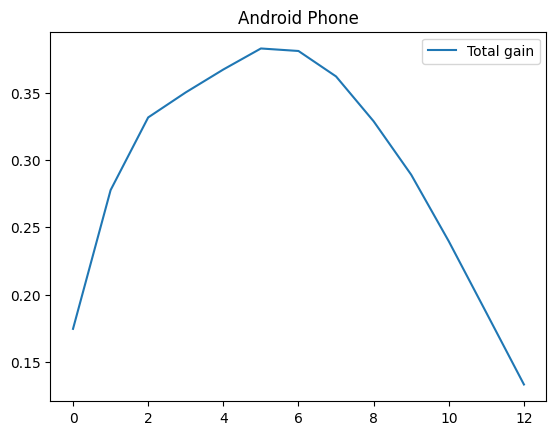

Number of features to use:  5
Blipcare Blood Pressure meter
Feature NO:  0 Total COST:  0.06666666666666667 Total GAIN:  0.3151009327921011 DIFF:  0.24843426612543446
Feature NO:  1 Total COST:  0.13333333333333333 Total GAIN:  0.5437413251451885 DIFF:  0.41040799181185517
Feature NO:  2 Total COST:  0.2 Total GAIN:  0.6888638286391165 DIFF:  0.48886382863911654
Feature NO:  3 Total COST:  0.26666666666666666 Total GAIN:  0.7721007874586533 DIFF:  0.5054341207919866
Feature NO:  4 Total COST:  0.3333333333333333 Total GAIN:  0.8203942306602509 DIFF:  0.48706089732691754
Feature NO:  5 Total COST:  0.4 Total GAIN:  0.8661232632363018 DIFF:  0.4661232632363018
Feature NO:  6 Total COST:  0.4666666666666667 Total GAIN:  0.9016382513847369 DIFF:  0.4349715847180702
Feature NO:  7 Total COST:  0.5333333333333333 Total GAIN:  0.9365501317883099 DIFF:  0.4032167984549766
Feature NO:  8 Total COST:  0.6 Total GAIN:  0.9651634265309778 DIFF:  0.3651634265309778
Feature NO:  9 Total COST:  0.666

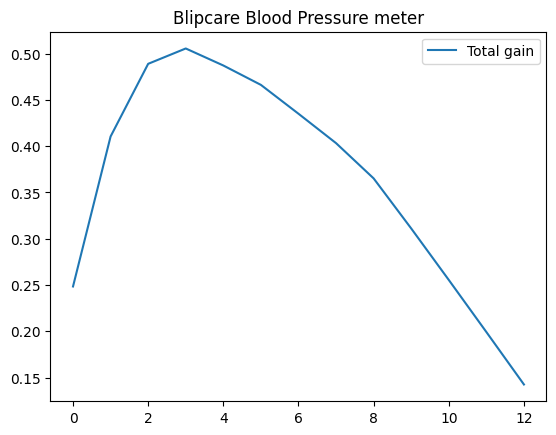

Number of features to use:  3
Dropcam
Feature NO:  0 Total COST:  0.06666666666666667 Total GAIN:  0.22325930622200402 DIFF:  0.15659263955533737
Feature NO:  1 Total COST:  0.13333333333333333 Total GAIN:  0.3772965660791357 DIFF:  0.24396323274580237
Feature NO:  2 Total COST:  0.2 Total GAIN:  0.49188917005115695 DIFF:  0.29188917005115694
Feature NO:  3 Total COST:  0.26666666666666666 Total GAIN:  0.5982929903032728 DIFF:  0.3316263236366061
Feature NO:  4 Total COST:  0.3333333333333333 Total GAIN:  0.6642242025450397 DIFF:  0.33089086921170635
Feature NO:  5 Total COST:  0.4 Total GAIN:  0.7301441297400925 DIFF:  0.33014412974009244
Feature NO:  6 Total COST:  0.4666666666666667 Total GAIN:  0.7951179835358504 DIFF:  0.3284513168691837
Feature NO:  7 Total COST:  0.5333333333333333 Total GAIN:  0.8465033843640044 DIFF:  0.3131700510306711
Feature NO:  8 Total COST:  0.6 Total GAIN:  0.8965509610918552 DIFF:  0.2965509610918552
Feature NO:  9 Total COST:  0.6666666666666666 Total

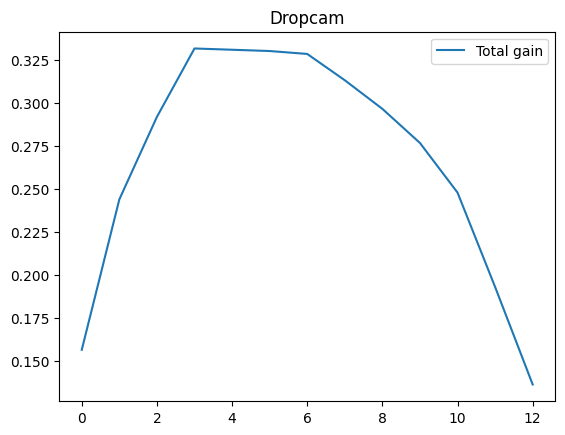

Number of features to use:  3
HP Printer
Feature NO:  0 Total COST:  0.06666666666666667 Total GAIN:  0.21395270456051582 DIFF:  0.14728603789384914
Feature NO:  1 Total COST:  0.13333333333333333 Total GAIN:  0.36158048305749374 DIFF:  0.2282471497241604
Feature NO:  2 Total COST:  0.2 Total GAIN:  0.4897433972654305 DIFF:  0.28974339726543047
Feature NO:  3 Total COST:  0.26666666666666666 Total GAIN:  0.6030470462840894 DIFF:  0.3363803796174228
Feature NO:  4 Total COST:  0.3333333333333333 Total GAIN:  0.68238248130932 DIFF:  0.3490491479759867
Feature NO:  5 Total COST:  0.4 Total GAIN:  0.759268624480131 DIFF:  0.35926862448013097
Feature NO:  6 Total COST:  0.4666666666666667 Total GAIN:  0.8241016411411428 DIFF:  0.35743497447447614
Feature NO:  7 Total COST:  0.5333333333333333 Total GAIN:  0.8711907503505789 DIFF:  0.3378574170172456
Feature NO:  8 Total COST:  0.6 Total GAIN:  0.9018088751195361 DIFF:  0.30180887511953614
Feature NO:  9 Total COST:  0.6666666666666666 Total

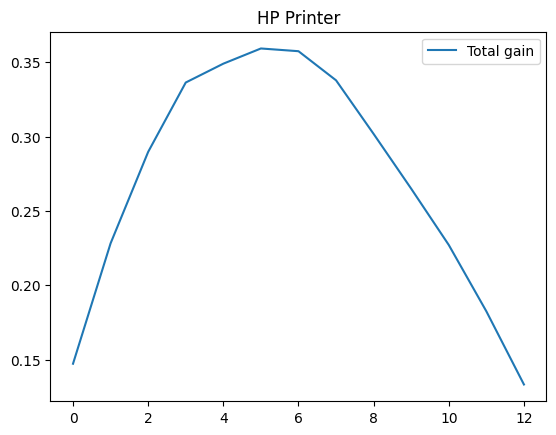

Number of features to use:  5
IPhone
Feature NO:  0 Total COST:  0.06666666666666667 Total GAIN:  0.43170928653316804 DIFF:  0.3650426198665014
Feature NO:  1 Total COST:  0.13333333333333333 Total GAIN:  0.5940382024535462 DIFF:  0.4607048691202129
Feature NO:  2 Total COST:  0.2 Total GAIN:  0.6775560833495018 DIFF:  0.4775560833495018
Feature NO:  3 Total COST:  0.26666666666666666 Total GAIN:  0.7454231280998568 DIFF:  0.4787564614331901
Feature NO:  4 Total COST:  0.3333333333333333 Total GAIN:  0.8113782457387652 DIFF:  0.47804491240543184
Feature NO:  5 Total COST:  0.4 Total GAIN:  0.8646852845888067 DIFF:  0.46468528458880665
Feature NO:  6 Total COST:  0.4666666666666667 Total GAIN:  0.9119946948390988 DIFF:  0.4453280281724321
Feature NO:  7 Total COST:  0.5333333333333333 Total GAIN:  0.957163366194035 DIFF:  0.42383003286070164
Feature NO:  8 Total COST:  0.6 Total GAIN:  0.9705223845241381 DIFF:  0.3705223845241381
Feature NO:  9 Total COST:  0.6666666666666666 Total GAIN

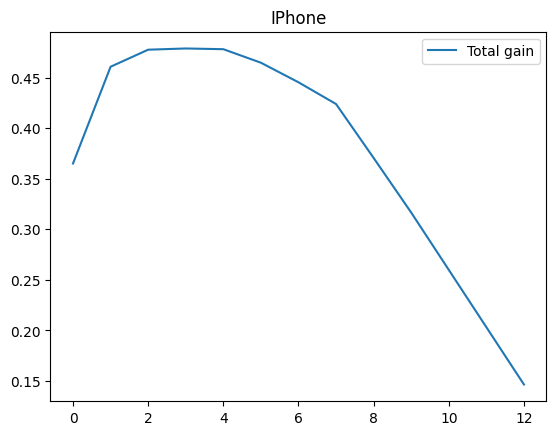

Number of features to use:  3
MacBook
Feature NO:  0 Total COST:  0.06666666666666667 Total GAIN:  0.3771519035701016 DIFF:  0.31048523690343494
Feature NO:  1 Total COST:  0.13333333333333333 Total GAIN:  0.5419684891883705 DIFF:  0.4086351558550372
Feature NO:  2 Total COST:  0.2 Total GAIN:  0.6871657513332077 DIFF:  0.48716575133320766
Feature NO:  3 Total COST:  0.26666666666666666 Total GAIN:  0.8030046982668237 DIFF:  0.5363380316001571
Feature NO:  4 Total COST:  0.3333333333333333 Total GAIN:  0.8488148805523141 DIFF:  0.5154815472189809
Feature NO:  5 Total COST:  0.4 Total GAIN:  0.89437751632627 DIFF:  0.49437751632627003
Feature NO:  6 Total COST:  0.4666666666666667 Total GAIN:  0.923662772897662 DIFF:  0.4569961062309953
Feature NO:  7 Total COST:  0.5333333333333333 Total GAIN:  0.9517265973904568 DIFF:  0.4183932640571235
Feature NO:  8 Total COST:  0.6 Total GAIN:  0.9722267732069965 DIFF:  0.3722267732069965
Feature NO:  9 Total COST:  0.6666666666666666 Total GAIN: 

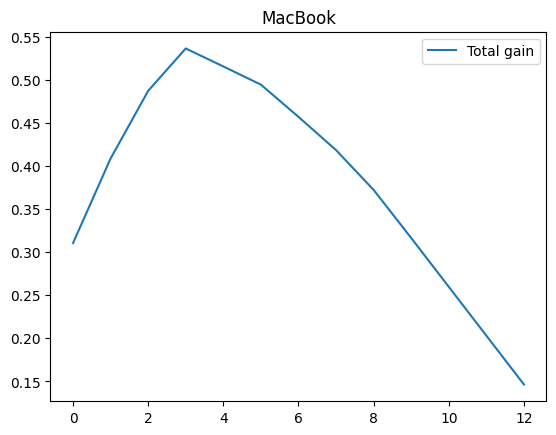

Number of features to use:  3
PIX-STAR Photo-frame
Feature NO:  0 Total COST:  0.06666666666666667 Total GAIN:  0.21814605605171344 DIFF:  0.1514793893850468
Feature NO:  1 Total COST:  0.13333333333333333 Total GAIN:  0.4133347122832685 DIFF:  0.28000137894993515
Feature NO:  2 Total COST:  0.2 Total GAIN:  0.5493204698429544 DIFF:  0.34932046984295434
Feature NO:  3 Total COST:  0.26666666666666666 Total GAIN:  0.6582790999266049 DIFF:  0.3916124332599383
Feature NO:  4 Total COST:  0.3333333333333333 Total GAIN:  0.7593575490876454 DIFF:  0.4260242157543121
Feature NO:  5 Total COST:  0.4 Total GAIN:  0.8428767215893874 DIFF:  0.4428767215893874
Feature NO:  6 Total COST:  0.4666666666666667 Total GAIN:  0.8972076018452775 DIFF:  0.4305409351786108
Feature NO:  7 Total COST:  0.5333333333333333 Total GAIN:  0.9384422986174437 DIFF:  0.40510896528411033
Feature NO:  8 Total COST:  0.6 Total GAIN:  0.9733716176589983 DIFF:  0.3733716176589983
Feature NO:  9 Total COST:  0.666666666666

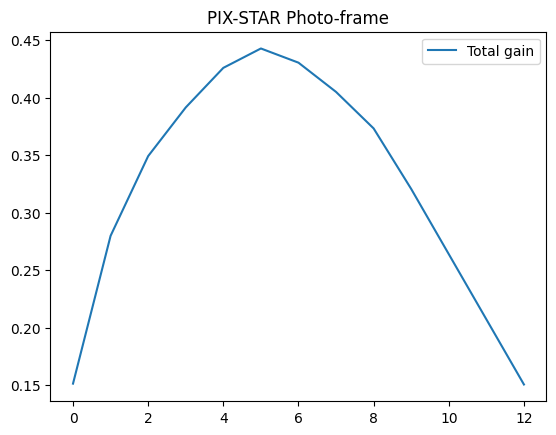

Number of features to use:  5
TP-Link Day Night Cloud camera
Feature NO:  0 Total COST:  0.06666666666666667 Total GAIN:  0.1902756270496738 DIFF:  0.12360896038300713
Feature NO:  1 Total COST:  0.13333333333333333 Total GAIN:  0.36019930003124156 DIFF:  0.22686596669790823
Feature NO:  2 Total COST:  0.2 Total GAIN:  0.4555751397750709 DIFF:  0.2555751397750709
Feature NO:  3 Total COST:  0.26666666666666666 Total GAIN:  0.5345720796757744 DIFF:  0.2679054130091077
Feature NO:  4 Total COST:  0.3333333333333333 Total GAIN:  0.6055961372002107 DIFF:  0.27226280386687735
Feature NO:  5 Total COST:  0.4 Total GAIN:  0.6750805648980407 DIFF:  0.27508056489804067
Feature NO:  6 Total COST:  0.4666666666666667 Total GAIN:  0.7408933043144107 DIFF:  0.274226637647744
Feature NO:  7 Total COST:  0.5333333333333333 Total GAIN:  0.8054620162294186 DIFF:  0.27212868289608527
Feature NO:  8 Total COST:  0.6 Total GAIN:  0.8688217600069956 DIFF:  0.26882176000699565
Feature NO:  9 Total COST:  0.

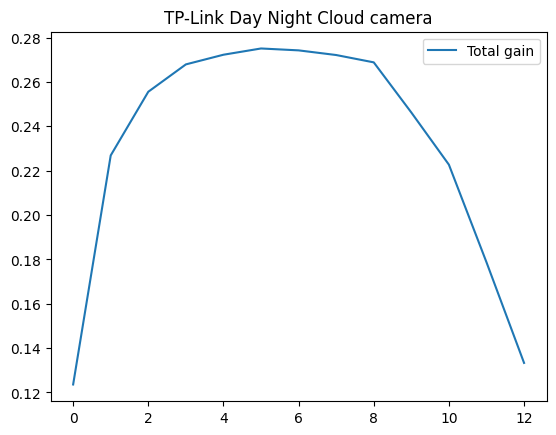

Number of features to use:  5
TP-Link Smart plug
Feature NO:  0 Total COST:  0.06666666666666667 Total GAIN:  0.24465842298606477 DIFF:  0.17799175631939812
Feature NO:  1 Total COST:  0.13333333333333333 Total GAIN:  0.4635489994647344 DIFF:  0.3302156661314011
Feature NO:  2 Total COST:  0.2 Total GAIN:  0.6616946137103962 DIFF:  0.46169461371039616
Feature NO:  3 Total COST:  0.26666666666666666 Total GAIN:  0.7667660636373431 DIFF:  0.5000993969706764
Feature NO:  4 Total COST:  0.3333333333333333 Total GAIN:  0.8511471374761385 DIFF:  0.5178138041428051
Feature NO:  5 Total COST:  0.4 Total GAIN:  0.9181858063698803 DIFF:  0.5181858063698803
Feature NO:  6 Total COST:  0.4666666666666667 Total GAIN:  0.9461797372784092 DIFF:  0.47951307061174253
Feature NO:  7 Total COST:  0.5333333333333333 Total GAIN:  0.9655333757398932 DIFF:  0.43220004240655985
Feature NO:  8 Total COST:  0.6 Total GAIN:  0.977202072681404 DIFF:  0.37720207268140404
Feature NO:  9 Total COST:  0.6666666666666

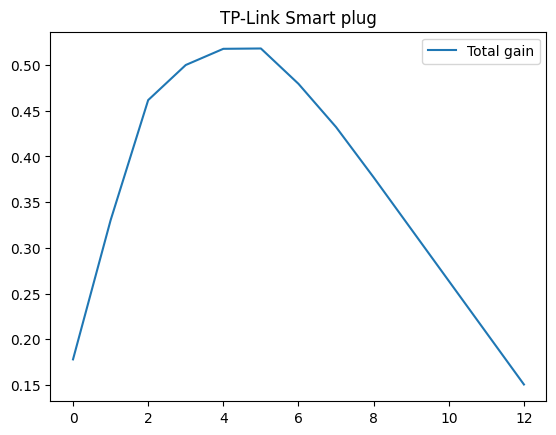

Number of features to use:  5


In [26]:
#### CALL flag_outliers per class - RELATIVE RATE of DECREASE
density_df = density_df.assign(outlier=True)
ord_param = 'normal_importances'
density_df = density_df.sort_values(by=ord_param,ascending=False).groupby('c_name', group_keys=False).apply(flag_outliers_with_cost, col_name=ord_param, th=0.65)
#
density_inliers_df = density_df[density_df['outlier']==False]

In [27]:
len(density_inliers_df)

46

In [28]:
#### CALL flag_imliers per class - DERIVATIVE BASED
# density_df = density_df.assign(outlier=True)
# density_df = density_df.sort_values(by='normal_importances',ascending=False).groupby('c_name', group_keys=False).apply(flag_inliers, threshold=0.05)
# #
# density_inliers_df = density_df[density_df['outlier']==False]

In [29]:
# imp_list = cum_increase_dict['Light Bulbs LiFX Smart Bulb']
# plt.plot(np.arange(len(imp_list)), imp_list)
# plt.show()

In [30]:
# take_derivative(classes_ordered[0], cum_increase_dict, 0.05)

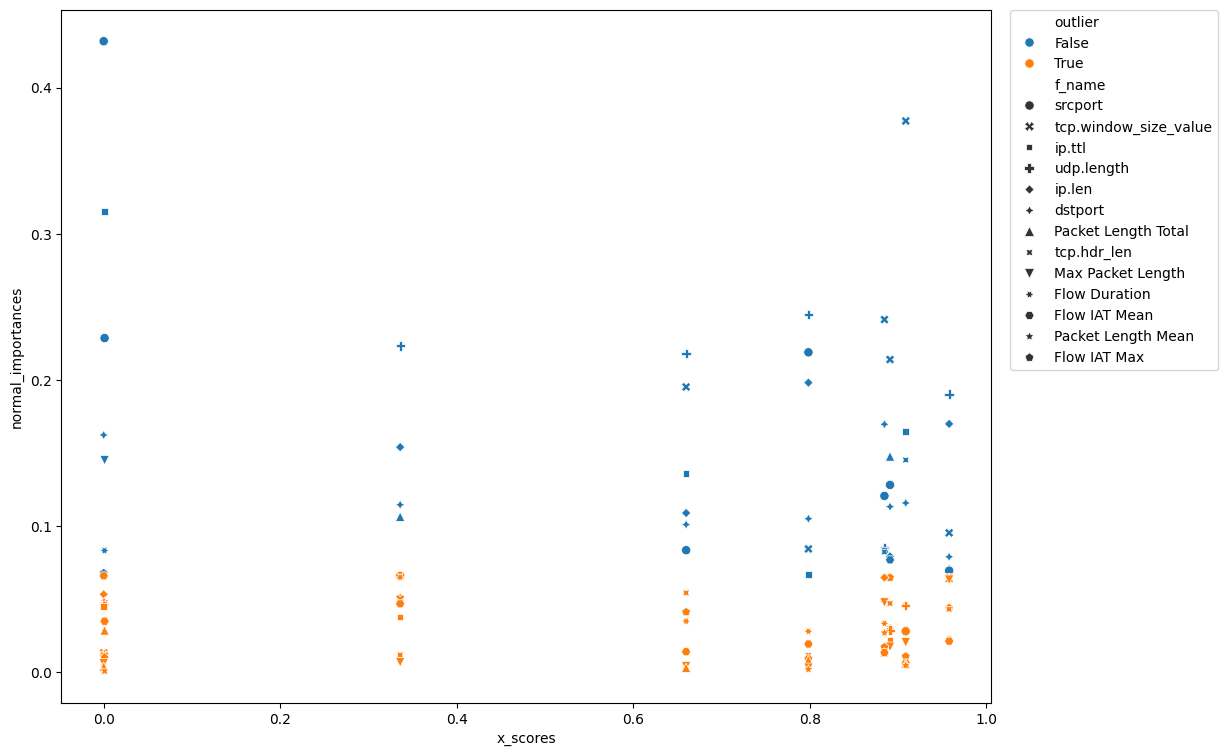

In [31]:
marker_lst = [
    ".", ",", "o", "v", "^", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", "*", "h", "H", "+", "x", "X",
    "D", "d", "|", "_", 0, 1, 2, 3, 4, 5
]
markers_dict = dict(zip(feature_names,marker_lst))

fig, ax = plt.subplots(figsize=(12,9))
sns.scatterplot(data=density_df, x='x_scores', y='normal_importances', ax=ax, hue='outlier', style="f_name", s=45)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# plt.xlim(0.85, 1)
plt.show()

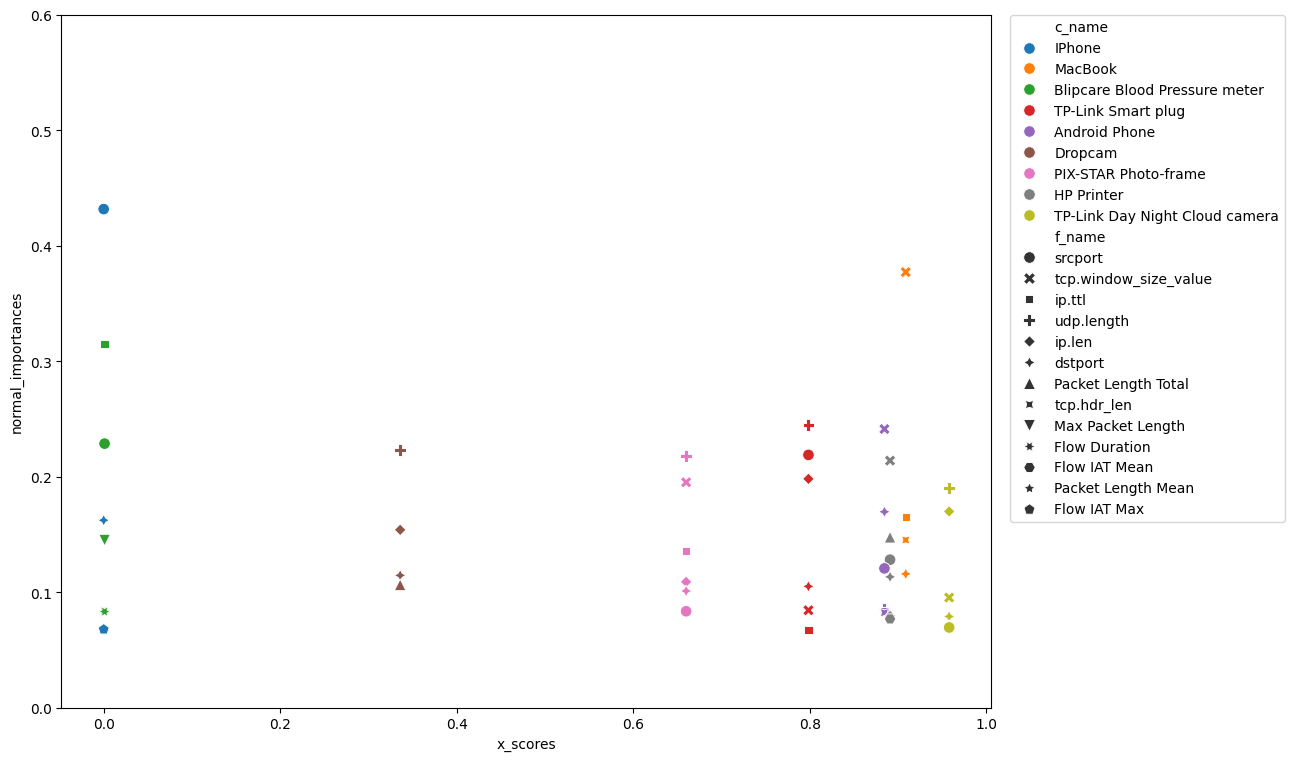

In [32]:
marker_lst = [
    ".", ",", "o", "v", "^", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", "*", "h", "H", "+", "x", "X",
    "D", "d", "|", "_", 0, 1, 2, 3, 4, 5
]
markers_dict = dict(zip(feature_names,marker_lst))

fig, ax = plt.subplots(figsize=(12,9))
sns.scatterplot(data=density_inliers_df, x='x_scores', y='normal_importances', ax=ax, hue='c_name', style="f_name", s=70)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.ylim(0, 0.6)
plt.show()

#### IQR to detect outliers

In [28]:
def detect_outliers_IQR(data_df):
    data = data_df['normal_importances'].to_list()
    Q1 = np.percentile(data, 25, interpolation = 'midpoint') 
    Q2 = np.percentile(data, 50, interpolation = 'midpoint') 
    Q3 = np.percentile(data, 75, interpolation = 'midpoint') 

    # print('Q1 25 percentile of the given data is, ', Q1)
    # print('Q1 50 percentile of the given data is, ', Q2)
    # print('Q1 75 percentile of the given data is, ', Q3)

    IQR = Q3 - Q1 
    # print('Interquartile range is', IQR)

    low_lim = Q1 - 0.75 * IQR
    up_lim = Q3 + 0.75 * IQR
    # print('low_limit is', low_lim)
    # print('up_limit is', up_lim)
    
    outlier =[]
    for x in data:
        # if ((x> up_lim) or (x<low_lim)):
        #     outlier.append(1)
        if  (x>up_lim):
            outlier.append(0)
        else:
            outlier.append(1)
    
    data_df['is_outlier'] = outlier
    
    if data_df['c_name'].unique()[0] == 'Light Bulbs LiFX Smart Bulb':
        print('outlier in the dataset is', outlier)
    return data_df


In [29]:
# density_df = density_df.assign(outlier=True)

density_df = density_df.sort_values(by='normal_importances',ascending=False).groupby('c_name').apply(detect_outliers_IQR)

outlier in the dataset is [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


#### Running Hamming Distance on the data obtained after Outlier Detection

In [33]:
## Generate Binary Array per class for inlier features
def generate_binary_arrays(df, binary_array_dict):
    binary_array = [int(i == False) for i in df['outlier'].to_list()]
    df['BinaryArray'] = [binary_array]*len(binary_array)
    binary_array_dict[df['c_name'].to_list()[0]] = binary_array
    return df
    
def assign_clusters(df, clustering_result, classes, clustering_method):
    df[clustering_method] = clustering_result[classes.index(df['c_name'].to_list()[0])]
    return df

def weighted_hamming_dist(distance_matrix, df):
    weighted_distance_matrix = distance_matrix.copy()
    ## get the classes in order
    classes_ordered = df.drop_duplicates(['c_name']).sort_values(by='x_scores', ascending=False)['c_name'].to_list()
    scores_ordered = df.drop_duplicates(['c_name']).sort_values(by='x_scores', ascending=False)['x_scores'].to_list()
    
    for i in range(0, len(weighted_distance_matrix)):
        for j in range(0, len(weighted_distance_matrix)):
            first_c_name = classes_ordered[i]
            second_c_name = classes_ordered[j]
            score_difference = abs(scores_ordered[i] - scores_ordered[j]) 
            # print(first_c_name, second_c_name, score_difference, weighted_distance_matrix[i][j])
            weighted_distance_matrix[i][j] = score_difference*weighted_distance_matrix[i][j]
            # print(weighted_distance_matrix[i][j])

    
    return weighted_distance_matrix

In [34]:
# data_to_cluster = density_df[density_df['x_scores'] > 0.7]
# data_to_cluster_inliers_df = density_inliers_df[density_inliers_df['x_scores'] > 0.7]

data_to_cluster = density_df
data_to_cluster_inliers_df = density_inliers_df

In [35]:
#### CALL generate_binary_arrays to GENERATE BINARY ARRAY STRINGS to check if the feature is inlier or outlier
data_to_cluster['f_name_ord'] = data_to_cluster['f_name'].replace(feature_names, range(len(feature_names)))
#
BinaryArray_dict = dict.fromkeys(data_to_cluster.sort_values(by='x_scores', ascending=False)['c_name'], None)
data_to_cluster['f_name_ord'] = data_to_cluster['f_name'].replace(feature_names, range(len(feature_names)))
#
ord_param = 'f_name_ord'
data_to_cluster = data_to_cluster.sort_values(by=ord_param,ascending=True).groupby('c_name', group_keys=False).apply(generate_binary_arrays, binary_array_dict=BinaryArray_dict)

In [36]:
#### Calculate Hamming Distance
dist = DistanceMetric.get_metric('hamming')
#define arrays
BinaryArray_Matrix = list(BinaryArray_dict.values())

# print(list(BinaryArray_dict.keys()))
# print(list(BinaryArray_dict.values()))
# hamming_distance = dist.pairwise(BinaryArray_Matrix)*len(BinaryArray_Matrix[0])
hamming_distance = dist.pairwise(BinaryArray_Matrix)

In [37]:
weighted_hamming_distance = weighted_hamming_dist(hamming_distance, data_to_cluster_inliers_df)

In [38]:
# # Initialize the Agglomerative clustering model
# model_average = AgglomerativeClustering(n_clusters=2, linkage='complete', affinity='precomputed')
# #
# clusters_average = model_average.fit_predict(hamming_distance)
# #
# # toy_data_df['AGGLOMERATIVE'] = clusters_average
# clusters_average

In [39]:
# Initialize the Agglomerative clustering model
model_average = AgglomerativeClustering(n_clusters=2, linkage='complete', affinity='precomputed')
#
clusters_average = model_average.fit_predict(weighted_hamming_distance)
#
# toy_data_df['AGGLOMERATIVE'] = clusters_average
clusters_average

array([1, 1, 1, 1, 1, 1, 0, 0, 0])

In [40]:
data_to_cluster = data_to_cluster.groupby('c_name', group_keys=False).apply(assign_clusters, clustering_result=clusters_average, classes=classes_ordered, clustering_method='Agg_Cluster')
#
data_to_cluster_inliers_df = data_to_cluster_inliers_df.groupby('c_name', group_keys=False).apply(assign_clusters, clustering_result=clusters_average, classes=classes_ordered, clustering_method='Agg_Cluster')

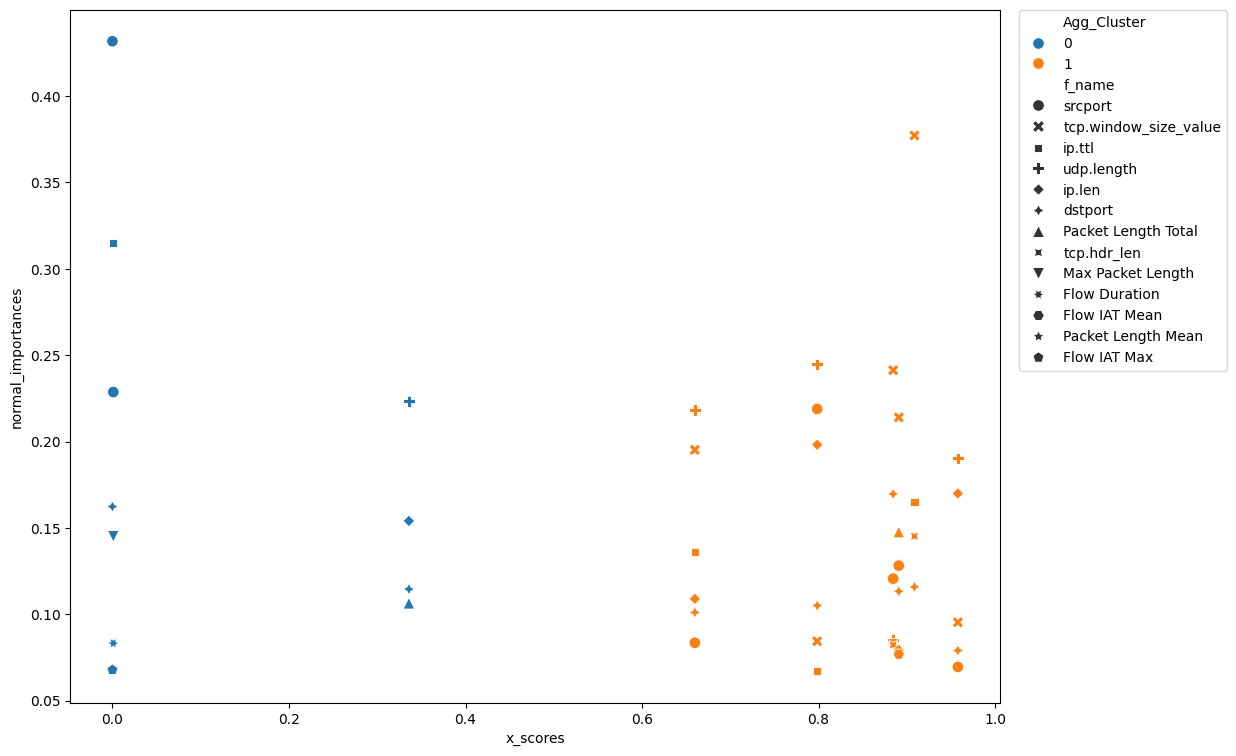

In [41]:
marker_lst = [
    ".", ",", "o", "v", "^", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", "*", "h", "H", "+", "x", "X",
    "D", "d", "|", "_", 0, 1, 2, 3, 4, 5
]
markers_dict = dict(zip(feature_names,marker_lst))

fig, ax = plt.subplots(figsize=(12,9))
sns.scatterplot(data=data_to_cluster_inliers_df, x='x_scores', y='normal_importances', ax=ax, hue='Agg_Cluster', style="f_name", s=70, palette="tab10")
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# plt.xlim(0.7, 1)
plt.show()

In [42]:
### To get statistics ###
score_per_class_df['Cluster_F1_Score'] = -1 
score_per_class_df['Cluster'] = list(clusters_average) + [-1]*(len(classes)- len(clusters_average))
#
x = score_per_class_df.groupby(by='Cluster')['class'].apply(list).to_dict()
cluster_info = pd.DataFrame()
cluster_info['Cluster'] = x.keys()
cluster_info['Class List'] = x.values()
cluster_info['Feature List'] = [-1]*len(cluster_info)
cluster_info['Depth'] =  -1 
cluster_info['Tree'] =  -1 
cluster_info['Feats'] =  -1 
#
pd.set_option('max_colwidth', None)
cluster_info

,Cluster,Class List,Feature List,Depth,Tree,Feats
0,0,"[Dropcam, Blipcare Blood Pressure meter, IPhone]",-1,-1,-1,-1
1,1,"[TP-Link Day Night Cloud camera, MacBook, HP Printer, Android Phone, TP-Link Smart plug, PIX-STAR Photo-frame]",-1,-1,-1,-1


In [43]:
#### To get cluster statistics ####
for cluster in list(set(clusters_average)):
    print('\n CLUSTER: ', cluster)
    cluster_df = data_to_cluster_inliers_df[data_to_cluster_inliers_df['Agg_Cluster'] == cluster]
    feat_importances_dict = cluster_df.groupby('f_name')['normal_importances'].mean().to_dict()
    feat_importance_df = pd.DataFrame()
    feat_importance_df['f_name'] = feat_importances_dict.keys()
    feat_importance_df['f_imp'] = feat_importances_dict.values()
    feat_importance_df = feat_importance_df.sort_values(by='f_imp', ascending=False)
    print('Number of Classes: ', len(cluster_df['c_name'].unique()))
    print('Number of Features: ', len(cluster_df['f_name'].unique()))
    print('------')
    print('Classes: ', cluster_df['c_name'].unique())
    print('Features: ', feat_importance_df['f_name'].to_list())
    print('Class Score: ', cluster_df['x_scores'].unique())
    print('------')
    #
    cluster_info.loc[cluster_info['Cluster'] == cluster, 'Feature List'] = str(feat_importance_df['f_name'].to_list())


 CLUSTER:  0
Number of Classes:  3
Number of Features:  9
------
Classes:  ['IPhone' 'Blipcare Blood Pressure meter' 'Dropcam']
Features:  ['srcport', 'ip.ttl', 'udp.length', 'ip.len', 'Max Packet Length', 'dstport', 'Packet Length Total', 'Flow Duration', 'Flow IAT Max']
Class Score:  [0.         0.001      0.33587463]
------

 CLUSTER:  1
Number of Classes:  6
Number of Features:  10
------
Classes:  ['MacBook' 'TP-Link Smart plug' 'Android Phone' 'PIX-STAR Photo-frame'
 'HP Printer' 'TP-Link Day Night Cloud camera']
Features:  ['tcp.window_size_value', 'udp.length', 'Packet Length Total', 'ip.len', 'srcport', 'dstport', 'tcp.hdr_len', 'ip.ttl', 'Flow IAT Mean', 'Packet Length Mean']
Class Score:  [0.9086244  0.79839429 0.88449223 0.6598252  0.89084023 0.95780987]
------


In [44]:
type(cluster_info.style.set_properties(**{'text-align': 'left'}))
cluster_info

,Cluster,Class List,Feature List,Depth,Tree,Feats
0,0,"[Dropcam, Blipcare Blood Pressure meter, IPhone]","['srcport', 'ip.ttl', 'udp.length', 'ip.len', 'Max Packet Length', 'dstport', 'Packet Length Total', 'Flow Duration', 'Flow IAT Max']",-1,-1,-1
1,1,"[TP-Link Day Night Cloud camera, MacBook, HP Printer, Android Phone, TP-Link Smart plug, PIX-STAR Photo-frame]","['tcp.window_size_value', 'udp.length', 'Packet Length Total', 'ip.len', 'srcport', 'dstport', 'tcp.hdr_len', 'ip.ttl', 'Flow IAT Mean', 'Packet Length Mean']",-1,-1,-1


In [44]:
# cluster = ['Netatmo weather station', 'Light Bulbs LiFX Smart Bulb', 'Smart Things']
# feats_to_use = ['dstport', 'ip.ttl', 'srcport', 'udp.length', 'tcp.hdr_len', 'ip.len', 'tcp.window_size_value', 'Flow IAT Mean']
# density_inliers_df[(density_inliers_df['c_name'].isin(cluster) & (density_inliers_df['f_name'].isin(feats_to_use)))].groupby(by='c_name')['normal_importances'].sum()

#### Model analysis results - per cluster

In [71]:
##### >70
cluster_id = 1
model_analysis_CL = read_csv(['/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/cluster_model_analysis_results/unsw_models_2pkts_PF_W_LeastSucClasses_Cluster1_OtherITSELF.csv'])
model_analysis_CL[(model_analysis_CL['tree']<3) ][['depth', 'tree', 'no_feats', 'Macro_f1_FL', 'Weighted_f1_FL', 'Micro_f1_FL', 'feats', 'cl_report_FL']].sort_values(by='Macro_f1_FL', ascending=False).head(8)

,depth,tree,no_feats,Macro_f1_FL,Weighted_f1_FL,Micro_f1_FL,feats,cl_report_FL
359,19,2,10,0.765656,0.872219,0.867883,"['srcport', 'tcp.hdr_len', 'dstport', 'ip.len', 'udp.length', 'tcp.window_size_value', 'ip.ttl', 'Flow IAT Mean', 'Packet Length Total', 'Packet Length Mean']","{'HP Printer': {'precision': 0.9909490479017121, 'recall': 0.7906457683342348, 'f1-score': 0.8795374393978542, 'support': 726.9999999998482}, 'PIX-STAR Photo-frame': {'precision': 0.5039390494715862, 'recall': 0.9293644911851503, 'f1-score': 0.6535155255193122, 'support': 184.00000000000094}, 'Android Phone': {'precision': 0.9565096066151733, 'recall': 0.8043273028310561, 'f1-score': 0.8738421916232219, 'support': 1524.9999999999861}, 'MacBook': {'precision': 0.8332261333054709, 'recall': 0.9640569078666076, 'f1-score': 0.893879696438101, 'support': 1340.999999999905}, 'TP-Link Day Night Cloud camera': {'precision': 0.9016472423245305, 'recall': 0.9814218315719135, 'f1-score': 0.9398447462820676, 'support': 294.99999999999187}, 'TP-Link Smart plug': {'precision': 0.8425336872055377, 'recall': 0.7584563296141502, 'f1-score': 0.798287311302028, 'support': 193.99999999999804}, 'Other': {'precision': 0.1909603857072245, 'recall': 0.9999984027600307, 'f1-score': 0.32068293638174744, 'support': 4.0000000000087566}, 'accuracy': 0.8678833611459574, 'macro avg': {'precision': 0.7456807360758908, 'recall': 0.889753004880449, 'f1-score': 0.7656556924206189, 'support': 4269.999999999739}, 'weighted avg': {'precision': 0.8944682555326735, 'recall': 0.8678833611460051, 'f1-score': 0.872219498964408, 'support': 4269.999999999739}}"
287,12,2,8,0.741830,0.855806,0.851703,"['srcport', 'tcp.hdr_len', 'dstport', 'udp.length', 'ip.len', 'tcp.window_size_value', 'ip.ttl', 'Flow IAT Mean']","{'HP Printer': {'precision': 0.9740732559183577, 'recall': 0.7652981165423709, 'f1-score': 0.8571561426516979, 'support': 726.9999999998482}, 'PIX-STAR Photo-frame': {'precision': 0.49022069200462837, 'recall': 0.954706735729798, 'f1-score': 0.6478069246491758, 'support': 184.00000000000094}, 'Android Phone': {'precision': 0.9487191441410647, 'recall': 0.7796059366103513, 'f1-score': 0.8558888431182186, 'support': 1524.9999999999861}, 'MacBook': {'precision': 0.8139608020329251, 'recall': 0.9680680528452411, 'f1-score': 0.8843509425331235, 'support': 1340.999999999905}, 'TP-Link Day Night Cloud camera': {'precision': 0.9065293628786821, 'recall': 0.9701331815790537, 'f1-score': 0.937253442396004, 'support': 294.99999999999187}, 'TP-Link Smart plug': {'precision': 0.8423426806555947, 'recall': 0.6570543509052728, 'f1-score': 0.7382499920008699, 'support': 193.99999999999804}, 'Other': {'precision': 0.1574753944705278, 'recall': 1.0, 'f1-score': 0.2721014981792557, 'support': 4.0000000000087566}, 'accuracy': 0.8517034929597617, 'macro avg': {'precision': 0.7333316188716829, 'recall': 0.8706951963160126, 'f1-score': 0.7418296836469064, 'support': 4269.999999999739}, 'weighted avg': {'precision': 0.8824685101632407, 'recall': 0.8517034929597863, 'f1-score': 0.8558062668578765, 'support': 4269.999999999739}}"
298,13,2,9,0.741449,0.852739,0.849896,"['srcport', 'tcp.hdr_len', 'dstport', 'udp.length', 'tcp.window_size_value', 'ip.len', 'ip.ttl', 'Flow IAT Mean', 'Packet Length Total']","{'HP Printer': {'precision': 0.9792101002918187, 'recall': 0.6831871688136734, 'f1-score': 0.8048422462244416, 'support': 726.9999999998482}, 'PIX-STAR Photo-frame': {'precision': 0.5447502446555589, 'recall': 0.9550086680969468, 'f1-score': 0.6937664462872811, 'support': 184.00000000000094}, 'Android Phone': {'precision': 0.9444417497788519, 'recall': 0.8088765378015922, 'f1-score': 0.8714182451956489, 'support': 1524.9999999999861}, 'MacBook': {'precision': 0.8015883033394292, 'recall': 0.9645186266119067, 'f1-score': 0.8755379828178561, 'support': 1340.999999999905}, 'TP-Link Day Night Cloud camera': {'precision': 0.9106260790944065, 'recall': 0.9348825892699757, 'f1-score': 0.9225949260211828, 'support': 294.

In [61]:
chosen_model = model_analysis_CL.loc[359]
cl_report = convert_str_to_dict(chosen_model['cl_report_FL'])
cluster_info.loc[cluster_info['Cluster'] == cluster_id, 'Depth'] = int(chosen_model['depth'])
cluster_info.loc[cluster_info['Cluster'] == cluster_id, 'Tree'] = chosen_model['tree']
cluster_info.loc[cluster_info['Cluster'] == cluster_id, 'Feats'] = chosen_model['no_feats']

In [62]:
result_dict = {}
for d_keys in cl_report.keys():
    if (d_keys != 'accuracy') and (d_keys != 'micro avg'):
        result_dict[d_keys] = cl_report[d_keys]['f1-score']
        if d_keys in classes:
            score_per_class_df.loc[score_per_class_df['class'] == d_keys, 'Cluster_F1_Score'] = cl_report[d_keys]['f1-score']*100
result_dict

{'HP Printer': 0.8795374393978542,
 'PIX-STAR Photo-frame': 0.6535155255193122,
 'Android Phone': 0.8738421916232219,
 'MacBook': 0.893879696438101,
 'TP-Link Day Night Cloud camera': 0.9398447462820676,
 'TP-Link Smart plug': 0.798287311302028,
 'Other': 0.32068293638174744,
 'macro avg': 0.7656556924206189,
 'weighted avg': 0.872219498964408}

In [63]:
score_per_class_df.loc[score_per_class_df['class'] == 'Blipcare Blood Pressure meter', 'f1_score'] = 1
score_per_class_df.loc[score_per_class_df['class'] == 'Cluster', 'f1_score'] = -1

In [67]:
score_per_class_df.sort_values(by='f1_score', ascending=False)[['class', 'f1_score', 'Cluster_F1_Score', 'Cluster']]

,class,f1_score,Cluster_F1_Score,Cluster
0,TP-Link Day Night Cloud camera,95.780987,93.984475,1
3,MacBook,90.862440,89.387970,1
2,HP Printer,89.084023,87.953744,1
1,Android Phone,88.449223,87.384219,1
5,TP-Link Smart plug,79.839429,79.828731,1
4,PIX-STAR Photo-frame,65.982520,65.351553,1
6,Dropcam,33.587463,75.861961,0
8,Blipcare Blood Pressure meter,1.000000,-1.000000,0
7,IPhone,0.000000,-1.000000,0


In [65]:
score_per_class_df.to_csv('second_model_cl_result_with_OtherAsLeastSucc.csv')

In [145]:
##### SCORE CALCULATION #####
### Without Unsuccessful Classes
df_cluster = score_per_class_df[score_per_class_df['f1_score'] > 70]

print('Macro (CL): ', np.mean(np.array(df_cluster['Cluster_F1_Score'])))
print('Macro (Main Model): ', np.mean(np.array(df_cluster['f1_score'])))

####
support_values = []
# class_flow_counts = flow_pkt_counts['label'].value_counts().to_dict()
for cl in df_cluster['class']:
    support_values.append(cl_report_FL[cl]['support'])
df_cluster['support'] = support_values
###

df_cluster['mult_f1'] = (df_cluster['support']*df_cluster['f1_score'])
df_cluster['mult_Cluster_f1'] = (df_cluster['support']*df_cluster['Cluster_F1_Score'])

print('Weighted (CL): ', df_cluster['mult_f1'].sum()/np.sum(np.array(support_values)))
print('Weighted (Main Model): ', df_cluster['mult_Cluster_f1'].sum()/np.sum(np.array(support_values)))


Macro (CL):  89.86113284084081
Macro (Main Model):  91.18757254359944
Weighted (CL):  93.30374584244484
Weighted (Main Model):  91.17649789290266


In [101]:
# score_per_class_df.to_csv('unsw_models_PF_W_All_Results.csv')

In [66]:
cluster_info

,Cluster,Class List,Feature List,Depth,Tree,Feats
0,0,"[Dropcam, Blipcare Blood Pressure meter, IPhone]","['srcport', 'ip.ttl', 'udp.length', 'ip.len', 'Max Packet Length', 'dstport', 'Packet Length Total', 'Flow Duration', 'Flow IAT Max']",10,1,2
1,1,"[TP-Link Day Night Cloud camera, MacBook, HP Printer, Android Phone, TP-Link Smart plug, PIX-STAR Photo-frame]","['tcp.window_size_value', 'udp.length', 'Packet Length Total', 'ip.len', 'srcport', 'dstport', 'tcp.hdr_len', 'ip.ttl', 'Flow IAT Mean', 'Packet Length Mean']",19,2,10


## Other Outlier Detection Methods - Based on Transformed Importance Value

In [18]:
def plot_outlier_detection(X, outliers_loc, title_name, n):
    # Plot anomly 
    colors=['green','red'] 

    fig, ax = plt.subplots(figsize=(15,12))
    for i in range(len(X)): 
        if i not in outliers_loc: 
            plt.scatter(X.iloc[i,0], X.iloc[i,1], color=colors[0]) # Not outlier 
        else: 
            plt.scatter(X.iloc[i,0], X.iloc[i,1], color=colors[1]) # Outlier 
    plt.xlabel('Score',fontsize=13) 
    plt.ylabel('exp(1/100*Importance)',fontsize=13)         
    plt.title(title_name,fontsize=16) 
    plt.ylim(0.5, n)        
    plt.show() 

#### Local Outlier Factor

In [19]:
### Local Outlier Factor for outlier detection
### The Local Outlier Factor (LOF) algorithm is an unsupervised anomaly detection method which computes the local density deviation of a given data point with respect to its neighbors.
from sklearn.neighbors import LocalOutlierFactor

X_LOF = density_df[density_df['exp_values'] < math.pow(10, 17)][['x_scores', 'exp_values']]

model_LOF = LocalOutlierFactor(n_neighbors=5, contamination=0.25)
# Fit the model to the training set X and return the labels.
y_pred = model_LOF.fit_predict(X_LOF)
# # Predict the labels (1 inlier, -1 outlier) of X according to LOF.
# y_pred_LOF = clf.predict(X)
# Calculate the outlier scores for each point 
scores_LOF = model_LOF.negative_outlier_factor_
##
# density_df['y_pred_LOF'] = y_pred
# density_df['X_scores_LOF'] = X_scores

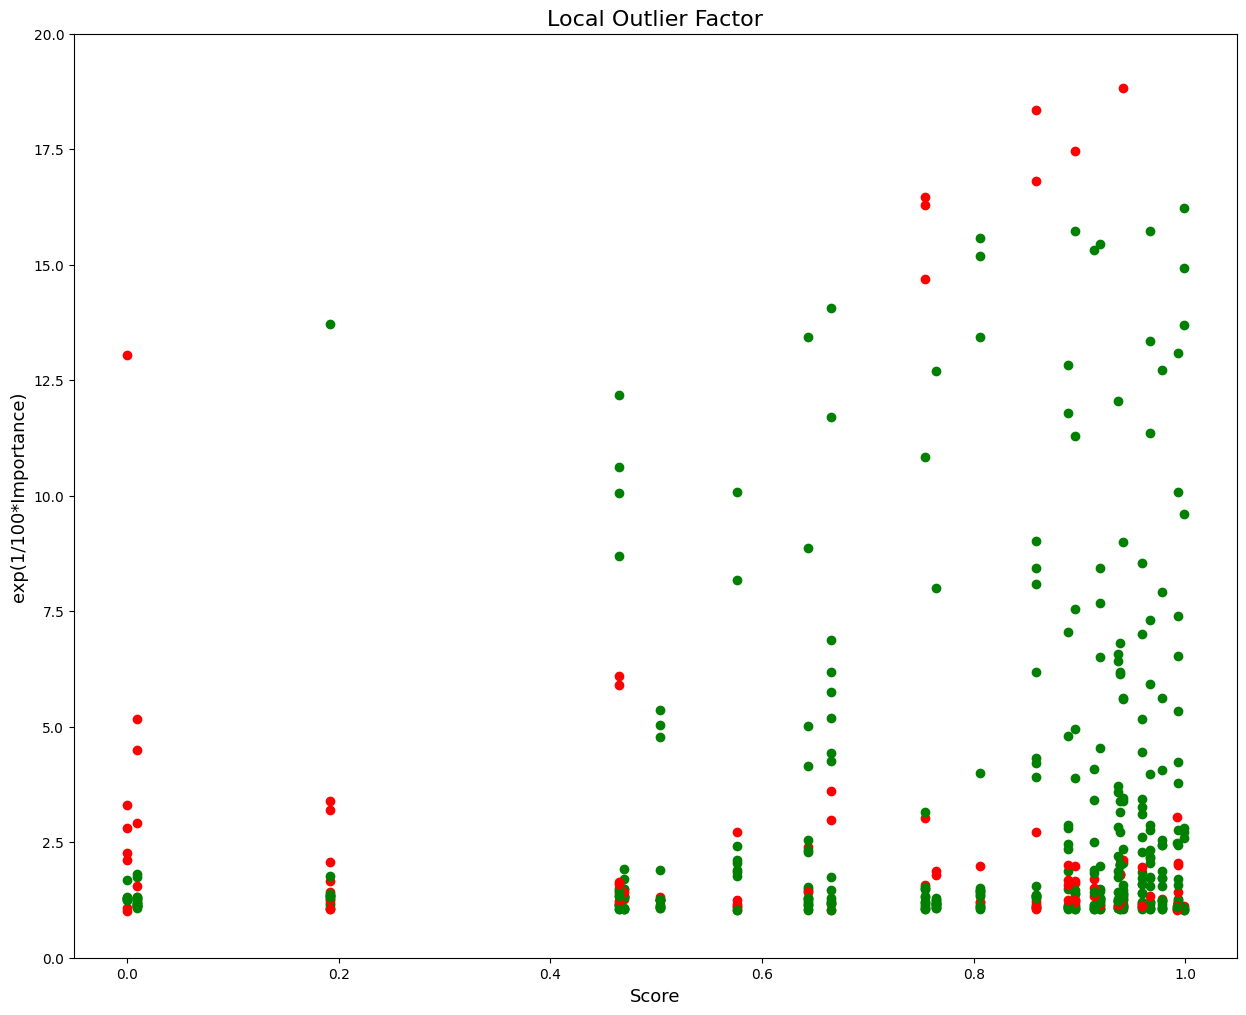

In [22]:
# Identify the points with the highest outlier scores 
outliers_LOF = np.argwhere(y_pred == -1) 

plot_outlier_detection(X_LOF, outliers_LOF, 'Local Outlier Factor', 20)

#### Isolation Forest

In [23]:
### Isolation Forest to detect outliers
### https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html
### The Isolation Forest algorithm is based on the idea that outliers are less frequent and, therefore, easier to isolate.
from sklearn.ensemble import IsolationForest


X_ISO = density_df[density_df['exp_values'] < math.pow(10, 17)][['x_scores', 'exp_values']]
# X = density_df[['x_scores', 'y_importances']]
# Create an Isolation Forest model
iso_forest = IsolationForest(contamination=0.1) # Adjust contamination based on your dataset
# Fit the model to your data
iso_forest.fit(X_ISO)
# Predict outliers
outliers = iso_forest.predict(X_ISO)
# Calculate the outlier scores for each point 
scores_iso = iso_forest.decision_function(X_ISO) 
##
# density_df['outliers_IF'] = outliers

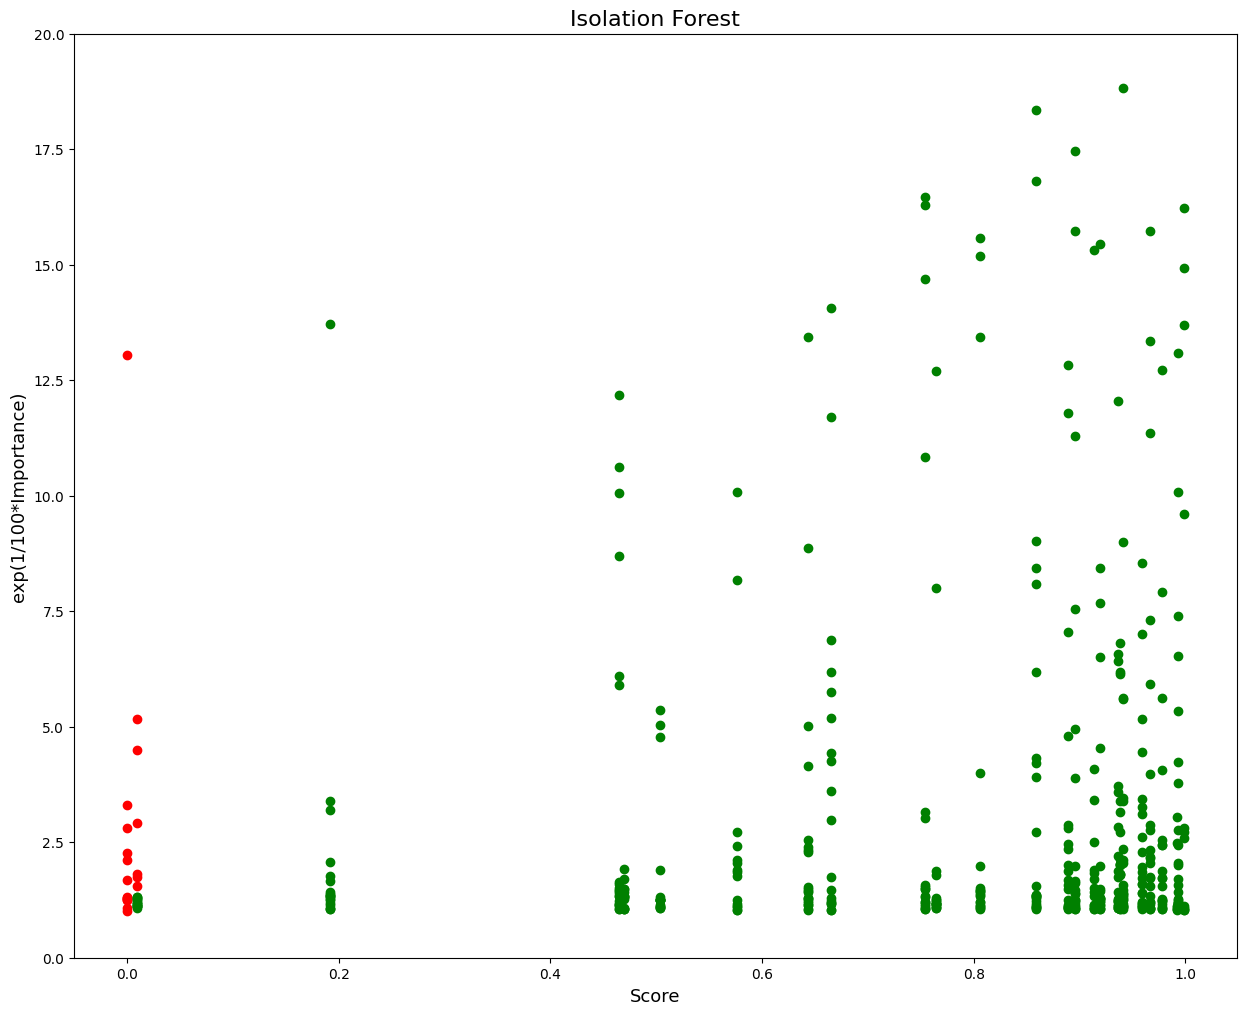

In [24]:
# Identify the points with the highest outlier scores 
outliers_ISO = np.argwhere(scores_iso < np.percentile(scores_iso, 10)) 
# outliers_ISO = np.argwhere(outliers == -1) 
  
plot_outlier_detection(X_ISO, outliers_ISO, 'Isolation Forest', 20)

#### One-Class SVM Outlier

In [25]:
# Import the necessary modules 
from sklearn import svm 

X_SVM = density_df[density_df['exp_values'] < math.pow(10, 17)][['x_scores', 'exp_values']]

# Define the model and set the nu parameter 
model_svm = svm.OneClassSVM(nu=0.5) 

# Fit the model to the data 
model_svm.fit(X_SVM) 
# y_pred = model_svm.predict(X_SVM) 

# Calculate the outlier scores for each point 
scores_svm = model_svm.decision_function(X_SVM) 

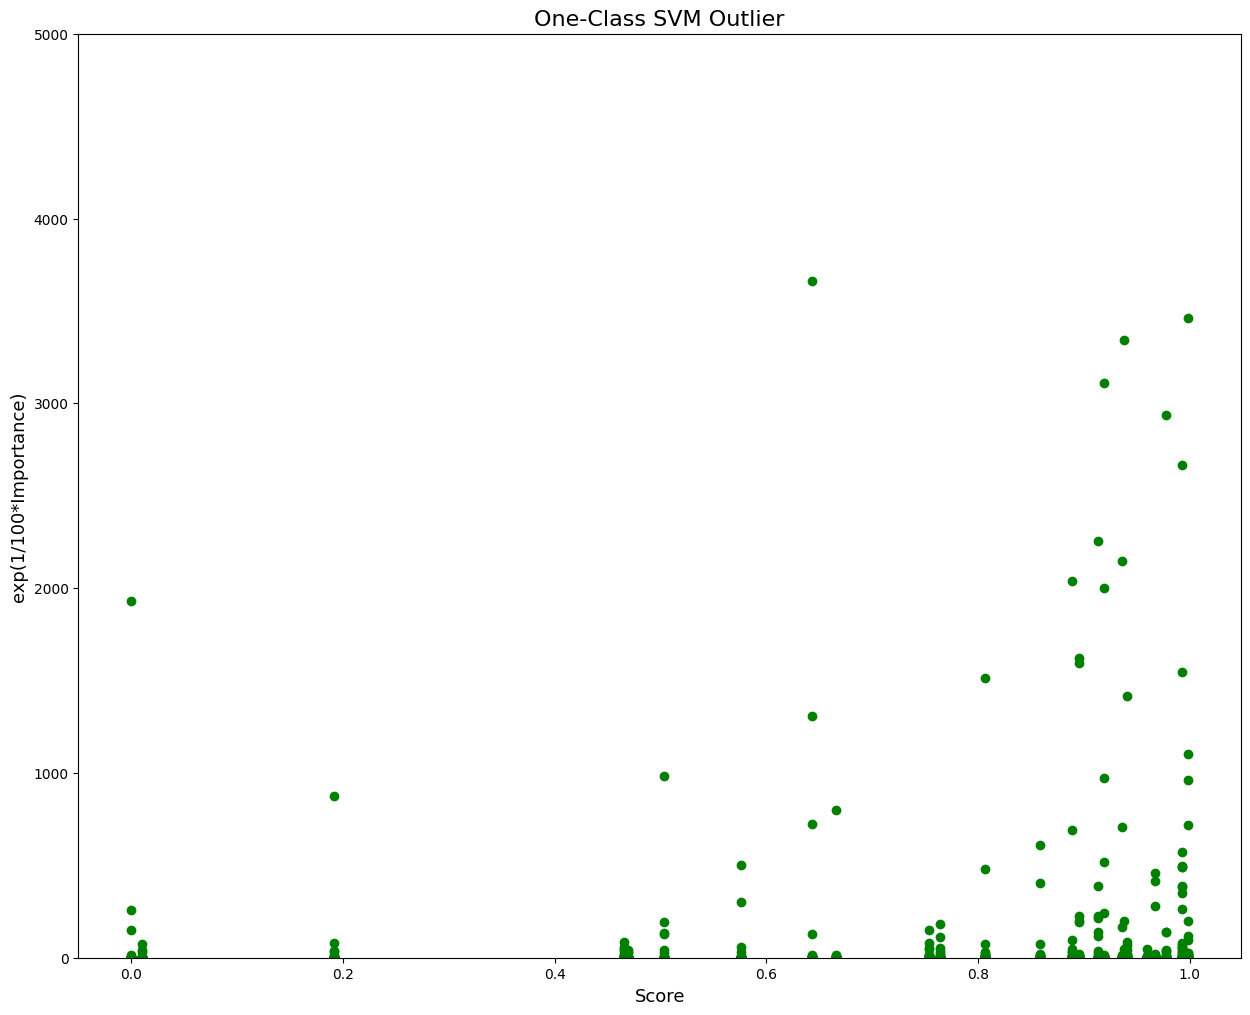

In [26]:
# Identify the points with the highest outlier scores 
outliers_SVM = np.argwhere(scores_svm < np.percentile(scores_svm, 10)) 
# outliers_SVM = np.argwhere(y_pred == -1) 

plot_outlier_detection(X_SVM, outliers_SVM, 'One-Class SVM Outlier', 5000)

#### Elliptic Envelope

In [202]:
# Import the necessary modules 
from sklearn.covariance import EllipticEnvelope 

# X = density_df[density_df['exp_values'] < 100000000000000000][['x_scores', 'exp_values']]
X_EllEnv = density_df[density_df['exp_values'] < math.pow(10, 17)][['x_scores', 'exp_values']]

# Define the model and set the contamination level 
model_EllEnv = EllipticEnvelope(contamination=0.47) 

# Fit the model to the data 
model_EllEnv.fit(X_EllEnv) 
y_pred = model_EllEnv.predict(X_EllEnv) 
# Calculate the outlier scores for each point 
scores_EllEnv = model_EllEnv.decision_function(X_EllEnv)


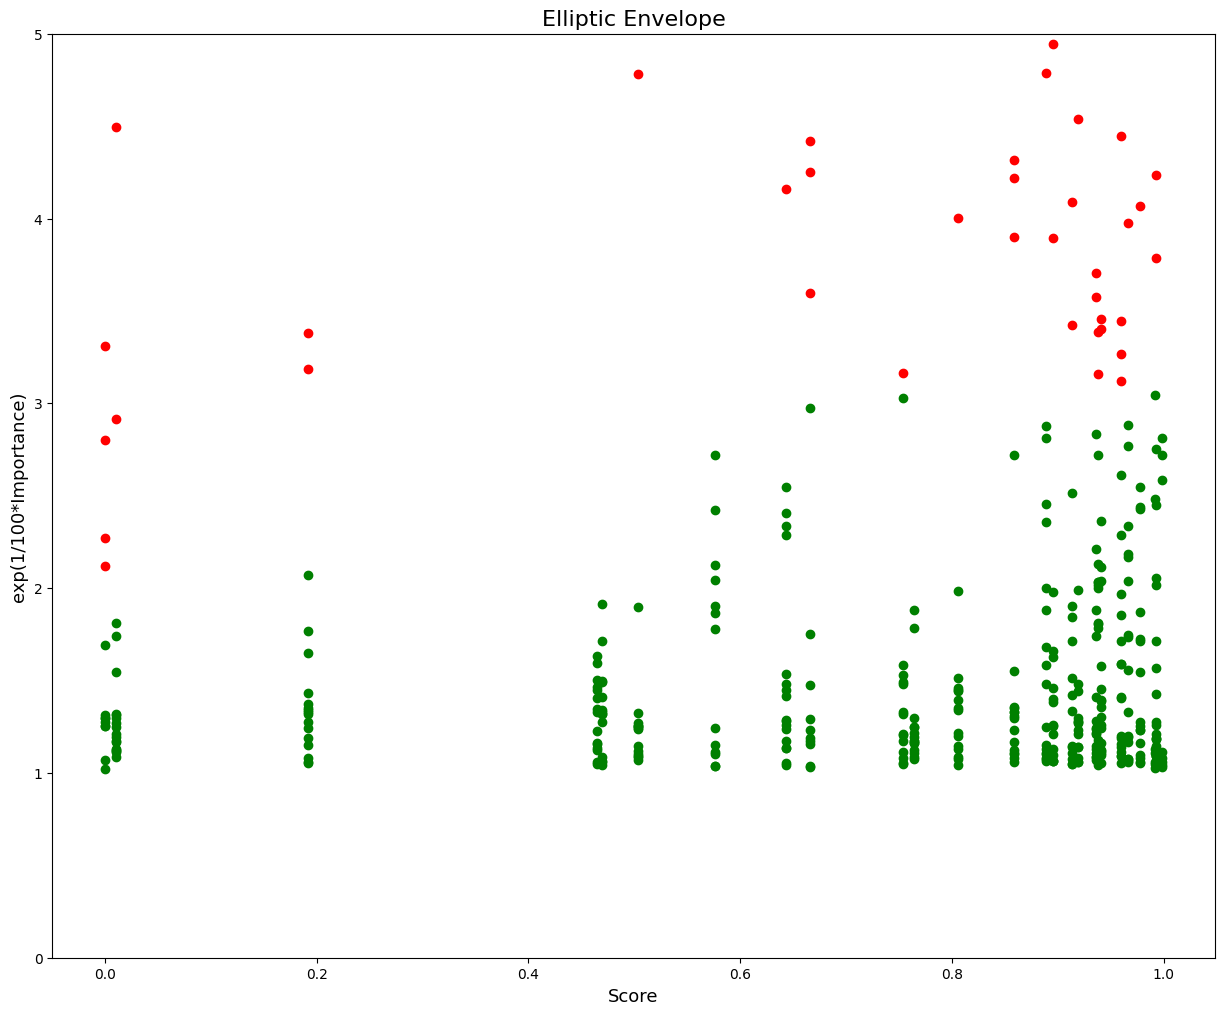

In [203]:
# Identify the points with the highest outlier scores 
# outliers_EllEnv = np.argwhere(scores_EllEnv < np.percentile(scores_EllEnv, 15)) 
outliers_EllEnv = np.argwhere(y_pred == -1) 

plot_outlier_detection(X_EllEnv, outliers_EllEnv, 'Elliptic Envelope', 5)

## TOY EXAMPLE

In [6]:
# !pip3 install gower

In [128]:
### TOY EXAMPLE DATA
### TOY1 ###
# transformed_importance = [0.005627, 0.00564, 0.00579, 0.15, 0.21, 0.7, 0.9,
#                           0.005629, 0.0058, 0.007, 0.992, 0.2, 0.8, 0.7,
#                           0.005627, 0.25, 0.98, 0.009, 0.85, 0.008, 0.006,
#                           0.007, 0.0055, 0.0061, 0.14, 0.97, 0.976, 0.79]
# score = [0.95, 0.992, 0.993, 0.995]
# classes_toy = ['C1', 'C2', 'C3', 'C4']
# ## Total 7 features
# feats = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
### TOY2 ###
# transformed_importance = [0.005627, 0.00564, 0.00579, 0.15, 0.21, 0.7, 0.9,
#                           0.87, 0.30, 0.91, 0.01, 0.88, 0.0089, 0.009,
#                           0.005629, 0.0058, 0.007, 0.992, 0.2, 0.8, 0.7,
#                           0.005627, 0.25, 0.98, 0.009, 0.85, 0.008, 0.006,
#                           0.007, 0.0055, 0.0061, 0.14, 0.97, 0.976, 0.79]
# score = [0.95, 0.96, 0.992, 0.993, 0.995]
# classes_toy = ['C1', 'C2', 'C3', 'C4', 'C5']
# ## Total 7 features
# feats = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
### TOY3 ###
# transformed_importance = [0.005627, 0.00564, 0.00579, 0.15, 0.21, 0.7, 0.9,
#                           0.87, 0.30, 0.91, 0.01, 0.88, 0.0089, 0.009,
#                           0.98, 0.004, 0.15, 0.72, 0.22, 0.009, 0.02,
#                           0.005629, 0.0058, 0.007, 0.992, 0.2, 0.8, 0.7, 
#                           0.005627, 0.25, 0.98, 0.009, 0.85, 0.008, 0.006,
#                           0.007, 0.0055, 0.0061, 0.14, 0.97, 0.976, 0.79]
# score = [0.95, 0.96, 0.97, 0.992, 0.993, 0.995]
# classes_toy = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']
# ## Total 7 features
# feats = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
### TOY4 ###
transformed_importance = [0.005627, 0.00564, 0.00579, 0.15, 0.21, 0.7, 0.9, 0.93,
                          0.87, 0.30, 0.91, 0.01, 0.88, 0.0089, 0.009, 0.94,
                          0.98, 0.004, 0.15, 0.72, 0.22, 0.009, 0.02, 0.99,
                          0.99, 0.98, 0.89, 0.91, 0.005, 0.99, 0.97, 0.0075, 
                          0.005629, 0.0058, 0.007, 0.992, 0.2, 0.8, 0.7, 0.89,
                          0.005627, 0.25, 0.98, 0.009, 0.85, 0.008, 0.006, 0.98,
                          0.007, 0.0055, 0.0061, 0.14, 0.97, 0.976, 0.79, 0.87]
score = [0.95, 0.96, 0.97, 0.98, 0.992, 0.993, 0.995]
classes_toy = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']
## Total 8 features
feats = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

In [129]:
#### Prepare the data of TOY EXAMPLE
toy_data_df = pd.DataFrame(columns=['transformed_importance', 'score', 'feats'])
toy_data_df['transformed_importance'] = transformed_importance
toy_data_df['score'] = [sc for sc in score for i in range(len(feats))]
toy_data_df['c_name'] = [cl for cl in classes_toy for i in range(len(feats))]
toy_data_df['feats'] = feats*len(score)

In [130]:
# toy_data_df.info()

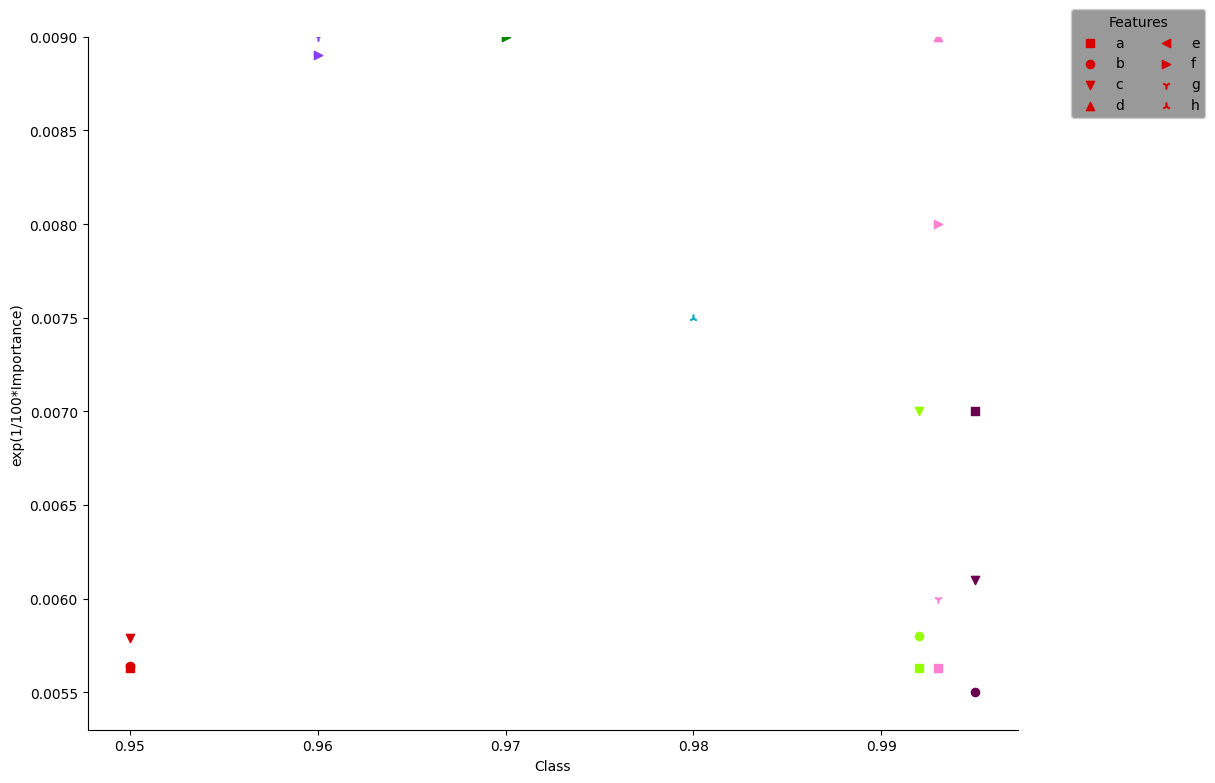

In [131]:
#### CLASS vs IMPORTANCE
## marker: to represent features
marker_lst = [
    ",", "o", "v", "^", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", "*", "h", "H", "+", "x", "X",
    "D", "d", "|", "_", 0, 1, 2, 3, 4, 5
]
## color: to represent classes
color_lst = sns.color_palette(cc.glasbey, n_colors=7)
color_marker_lst = [(c,m) for m in marker_lst for c in color_lst]
#
feature_names = feats
class_names = classes_toy
#
fig, ax = plt.subplots(figsize=(12,9))
#
for c in classes_toy:
    for j in np.arange(len(feature_names)):
        data_row = toy_data_df[(toy_data_df['c_name'] == c) & (toy_data_df['feats'] == feature_names[j])]
        #
        ax.scatter(data_row['score'].to_list()[0], data_row['transformed_importance'].to_list()[0], color=color_lst[classes_toy.index(c)], marker=marker_lst[j],
                s=35)

    
## plot feature importance threshold
# ax.hlines(y=25, xmin=-0, xmax=100, colors='k', linestyles='dashed', lw=1)
ax.legend(feature_names, bbox_to_anchor=(1.05, 1.05), title='Features', ncol=2, facecolor='gray')
ax.set_xlabel('Class')
ax.set_ylabel('exp(1/100*Importance)')
ax.set_ylim(bottom=0)
ax.set_ylim(0.0053, 0.009)
# ax.set_xlim(0.96, 1)
sns.despine(fig=fig)
plt.show()
plt.close()


### Clustering - TOY EXAMPLE

In [251]:
def plot_cluster_result(cl_method, classes, feature_names, cluster_data, x_column_name, y_column_name):    
    #### CLASS vs IMPORTANCE
    ## marker: to represent features
    marker_lst = [
        ",", "o", "v", "^", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", "*", "h", "H", "+", "x", "X",
        "D", "d", "|", "_", 0, 1, 2, 3, 4, 5
    ]
    ## color: to represent classes
    color_lst = sns.color_palette(cc.glasbey, n_colors=20)
    #
    fig, ax = plt.subplots(figsize=(12,9))
    for c in classes:
        for j in np.arange(len(feature_names)):
            try:
                data_row = cluster_data[(cluster_data['c_name'] == c) & (cluster_data['f_name'] == feature_names[j])]
                #
                if data_row[cl_method].to_list()[0] == -1: ### Outlier
                    ax.scatter(data_row[x_column_name].to_list()[0], data_row[y_column_name].to_list()[0], color='gray', marker=marker_lst[j],
                            s=45)
                else:
                    ax.scatter(data_row[x_column_name].to_list()[0], data_row[y_column_name].to_list()[0], color=color_lst[data_row[cl_method].to_list()[0]], marker=marker_lst[j],
                            s=45)
            except:
                continue

    ax.legend(feature_names, bbox_to_anchor=(1.05, 1.05), title='Features', ncol=2, facecolor='gray')
    ax.set_xlabel('Class')
    ax.set_ylabel('exp(1/100*Importance)')
    ax.set_ylim(bottom=0)
    ax.set_ylim(0.36, 0.5)
    sns.despine(fig=fig)
    plt.show()
    plt.close()

In [114]:
### Gower Distance
# distance_matrix = gower.gower_matrix(toy_data_df[['score', 'feats', 'transformed_importance']])

In [189]:
X_toy = toy_data_df.copy()
for feat in feats:
    X_toy['F'+feat] = np.where(X_toy['feats'] == feat, 1, 0)
#
X_toy = X_toy.drop(['c_name', 'feats'], axis=1)

In [190]:
#### Weighted Euclidean Distance
distance_values = []
weights = []
# The first point
for point1_ind in range(0, len(toy_data_df)):
    dist_array = []
    Point_1 = X_toy.iloc[point1_ind].to_numpy()
    Feat_1 = toy_data_df.iloc[point1_ind]['feats']
    Class_1 = toy_data_df.iloc[point1_ind]['c_name']
    # Get the Transformed Importance value of Point_1 and Find the closest X points in terms of Transformed Importance (same class)
    tr_importance_1 = toy_data_df.iloc[point1_ind]['transformed_importance']
    df_Point_1 = toy_data_df[toy_data_df['c_name'] == Class_1]
    df_Point_1['difference'] = abs(df_Point_1['transformed_importance'] - tr_importance_1)
    closest_points_1 = df_Point_1.sort_values(by='difference')[1:3]['feats'].to_list()
    #
    # The second point
    for point2_ind in range(0, len(toy_data_df)):
        Point_2 = X_toy.iloc[point2_ind].to_numpy()
        Feat_2 = toy_data_df.iloc[point2_ind]['feats']
        Class_2 = toy_data_df.iloc[point2_ind]['c_name']
        # Get the Transformed Importance value of Point_2 and Find the closest X points in terms of Transformed Importance (same class)
        tr_importance_2 = toy_data_df.iloc[point2_ind]['transformed_importance']
        df_Point_2 = toy_data_df[toy_data_df['c_name'] == Class_2]
        df_Point_2['difference'] = abs(df_Point_2['transformed_importance'] - tr_importance_2)
        closest_points_2 = df_Point_2.sort_values(by='difference')[1:3]['feats'].to_list()
        # Find the difference between the closest points of Point_1 and Point_2
        different_points = list(set(closest_points_1).symmetric_difference(set(closest_points_2)))
        #
        ## The DISTANCE between 2 points (EUC)
        euc_distance = math.dist(Point_1, Point_2)
        ##
        #
        # point3_ind = toy_data_df[(toy_data_df['c_name'] == Class_2) & (toy_data_df['feats'] == Feat_1)].index.to_list()[0]
        # point4_ind = toy_data_df[(toy_data_df['c_name'] == Class_1) & (toy_data_df['feats'] == Feat_2)].index.to_list()[0]
        # Point3 = X_toy.iloc[point3_ind].to_numpy()
        # Point4 = X_toy.iloc[point4_ind].to_numpy()
        ##
        ### Dist(F1C1, F2C2) + Dist(F1C1, F1C2) ###
        # weight = math.dist(Point_2, point3)
        #
        ### Dist(F1C1, F2C2) + Dist(F2C2, F1C2) ###
        # weight = math.dist(Point_2, point3)
        #
        ### Distance calculated with the weight = Dist(F1C1, F1C2) + Dist(F2C1, F2C2)
        # weight = math.dist(Point_1, point3) + math.dist(Point_2, Point4)
        #
        ### Distance weighted by un-common features
        # weight = len(different_feats)
        #
        ### Distance weighted by the distance of un-common features(points)
        # if Feat_1 in different_points:
        #     different_points.remove(Feat_1)
        # if Feat_2 in different_points:   
        #     different_points.remove(Feat_2)
        distances_between_neighbors = []
        ## Difference between the same feats in different Class
        for d_feat in different_points:
            p1 = X_toy.iloc[toy_data_df[(toy_data_df['c_name'] == Class_1) & (toy_data_df['feats'] == d_feat)].index.to_list()[0]].to_numpy() ## FC1
            p2 = X_toy.iloc[toy_data_df[(toy_data_df['c_name'] == Class_2) & (toy_data_df['feats'] == d_feat)].index.to_list()[0]].to_numpy() ## FC2
            # if Class_1 == 'C3' and class2 == 'C4':
            #     print(p1)
            #     print(p2)
            distances_between_neighbors.append(math.dist(p1,p2))
        if Class_1 == 'C5' and Class_2 == 'C7' and Feat_1 == 'b' and Feat_2 == 'c':
            print(different_points)
        ## Difference between each neighbor 
        # for d_feat_1 in closest_points_1:
        #     for d_feat_2 in closest_points_2:
        #         if (d_feat_2 in different_points) and (d_feat_1 in different_points):
        #             p1 = X_toy.iloc[toy_data_df[(toy_data_df['c_name'] == Class_1) & (toy_data_df['feats'] == d_feat_1)].index.to_list()[0]].to_numpy() ## FC1
        #             p2 = X_toy.iloc[toy_data_df[(toy_data_df['c_name'] == Class_2) & (toy_data_df['feats'] == d_feat_2)].index.to_list()[0]].to_numpy() ## FC2

        #             distances_between_neighbors.append(math.dist(p1,p2))
        
        #
        if Class_1 == Class_2:                         #C1==C2
            if Feat_1 in different_points:
                different_points.remove(Feat_1)
            if Feat_2 in different_points:   
                different_points.remove(Feat_2)
            weight = len(different_points)
            dist_array.append(euc_distance*weight)
        else:                                           #C1!=C2
            weight = sum(distances_between_neighbors)
            dist_array.append(euc_distance+weight)
            
        # Analysis purposes
        # if Class_1 == 'C2' and Class_2 == 'C4' and Feat_1 == 'b' and Feat_2 == 'a':
        #     print(euc_distance)
        #     print(weight)
        #     print(euc_distance*weight)
        #     print(different_points)

    distance_values.append(dist_array)
# distance_values

['c', 'b']


#### Clustering approaches

In [191]:
# Initialize the DBSCAN clustering model
dbscan = DBSCAN(eps=0.002, min_samples=2, metric='precomputed')
# Fit the model to the data
dbscan.fit(distance_values)
 
# Get the cluster labels
labels = dbscan.labels_
toy_data_df['DBSCAN'] = labels

labels

array([ 0,  0,  0,  1,  1,  2,  2,  2,  3,  4,  3,  4,  3,  4,  4,  3,  5,
        6,  7,  5,  7,  6,  6,  5,  8,  8,  9,  9, 10,  8, -1, 10, 11, 11,
       11, 12, 11, 12, 12, 12, 13, -1, 14, 13, 14, 13, 13, 14, 15, 15, 15,
       15, 16, 16, 16, 16])

In [134]:
# Initialize the OPTICS clustering model
optics = OPTICS(min_samples=2, metric='precomputed')
# Fit the model to the data
optics.fit(distance_values)
 
# Get the cluster labels
labels = optics.labels_
toy_data_df['OPTICS'] = labels

labels

array([ 0,  0,  0,  8,  8, 12, 12, 12,  5,  9,  5,  9,  5,  9,  9,  5,  7,
       13,  3,  7,  3, 13, 13,  7, 16, 16, 15, 15,  6, 16, 16,  6,  1,  1,
        1, 11,  1, 11, 11, 11, 10, -1,  4, 10,  4, 10, 10,  4,  2,  2,  2,
        2, 14, 14, 14, 14])

In [135]:
# Initialize the HDBSCAN clustering model
hdbscan = HDBSCAN(min_cluster_size=2, metric='precomputed')
 
# Fit the model to the data
optics.fit(distance_values)
 
# Get the cluster labels
labels = optics.labels_
toy_data_df['HDBSCAN'] = labels

labels

array([ 0,  0,  0,  8,  8, 12, 12, 12,  5,  9,  5,  9,  5,  9,  9,  5,  7,
       13,  3,  7,  3, 13, 13,  7, 16, 16, 15, 15,  6, 16, 16,  6,  1,  1,
        1, 11,  1, 11, 11, 11, 10, -1,  4, 10,  4, 10, 10,  4,  2,  2,  2,
        2, 14, 14, 14, 14])

In [138]:
# Initialize the Agglomerative clustering model
model_average = AgglomerativeClustering(n_clusters=7, linkage='average', affinity='precomputed')
#
clusters_average = model_average.fit_predict(distance_values)
#
toy_data_df['AGGLOMERATIVE'] = clusters_average
clusters_average

array([4, 4, 4, 0, 0, 2, 2, 2, 0, 5, 0, 5, 0, 5, 5, 0, 6, 5, 1, 6, 1, 5,
       5, 6, 3, 3, 1, 1, 0, 3, 3, 0, 4, 4, 4, 2, 4, 2, 2, 2, 5, 5, 0, 5,
       0, 5, 5, 0, 4, 4, 4, 4, 2, 2, 2, 2])

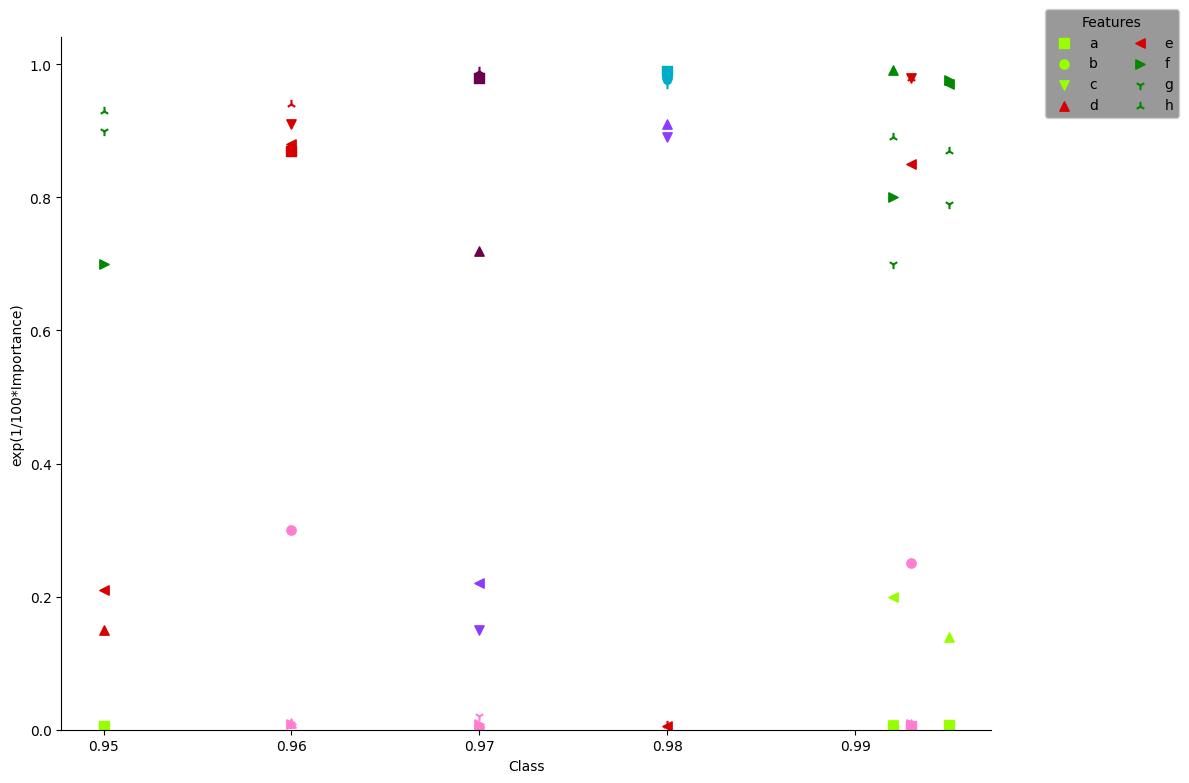

In [139]:
plot_cluster_result('AGGLOMERATIVE', classes_toy, feats, toy_data_df, 'score', 'transformed_importance')

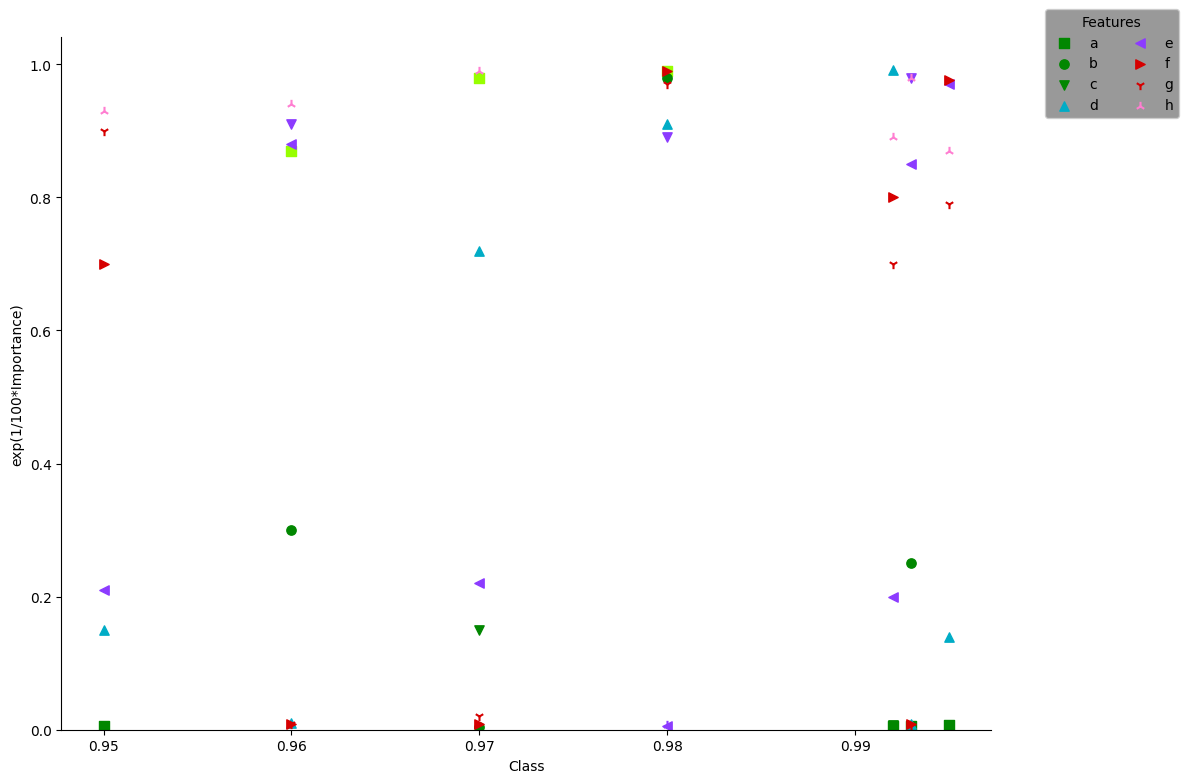

In [131]:
plot_cluster_result('AGGLOMERATIVE', classes_toy, feats)

## CLUSTERING
#### To be visited later. I will continue with a toy example.

In [231]:
filtered_density_df = density_df[density_df['exp_values'] < math.pow(10, 17)]

In [232]:
X_EllEnv = filtered_density_df[['x_scores', 'exp_values']]

# Define the model and set the contamination level 
model_EllEnv = EllipticEnvelope(contamination=0.50) 

# Fit the model to the data 
model_EllEnv.fit(X_EllEnv) 
y_pred = model_EllEnv.predict(X_EllEnv) 
# Calculate the outlier scores for each point 
scores_EllEnv = model_EllEnv.decision_function(X_EllEnv)

filtered_density_df['outliers_EllEnv'] = y_pred

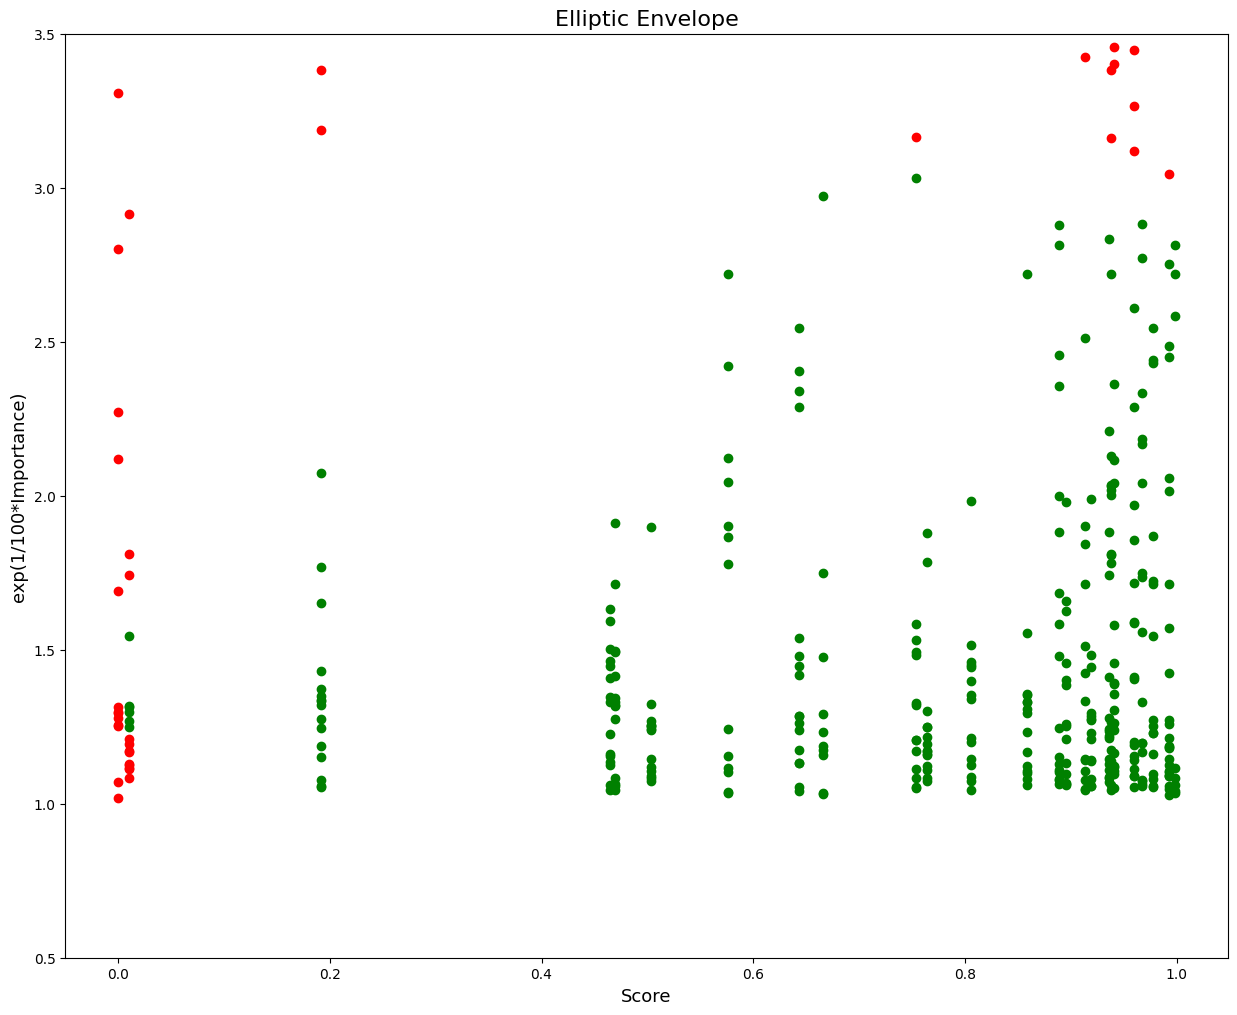

In [233]:
# Identify the points with the highest outlier scores 
# outliers_EllEnv = np.argwhere(scores_EllEnv < np.percentile(scores_EllEnv, 15)) 
outliers_EllEnv = np.argwhere(y_pred == -1) 

plot_outlier_detection(X_EllEnv, outliers_EllEnv, 'Elliptic Envelope', 3.5)

In [234]:
cluster_data = filtered_density_df[filtered_density_df['outliers_EllEnv'] == 1]
cluster_data = cluster_data[['c_name', 'f_name', 'Feature', 'exp_values', 'x_scores']]

In [149]:
cluster_data

,c_name,f_name,Feature,exp_values,x_scores
0,Light Bulbs LiFX Smart Bulb,ip.len,0,1.115817,0.998366
1,Light Bulbs LiFX Smart Bulb,ip.ttl,1,1.041925,0.998366
8,Light Bulbs LiFX Smart Bulb,ip.proto,8,2.813918,0.998366
9,Light Bulbs LiFX Smart Bulb,srcport,9,1.082076,0.998366
10,Light Bulbs LiFX Smart Bulb,dstport,10,1.033912,0.998366
...,...,...,...,...,...
791,Blipcare Blood Pressure meter,Max Packet Length,16,1.316499,0.010000
797,Blipcare Blood Pressure meter,Flow IAT Max,22,1.299421,0.010000
799,Blipcare Blood Pressure meter,Flow Duration,24,1.267528,0.010000
802,Blipcare Blood Pressure meter,PSH Flag Count,27,1.312686,0.010000


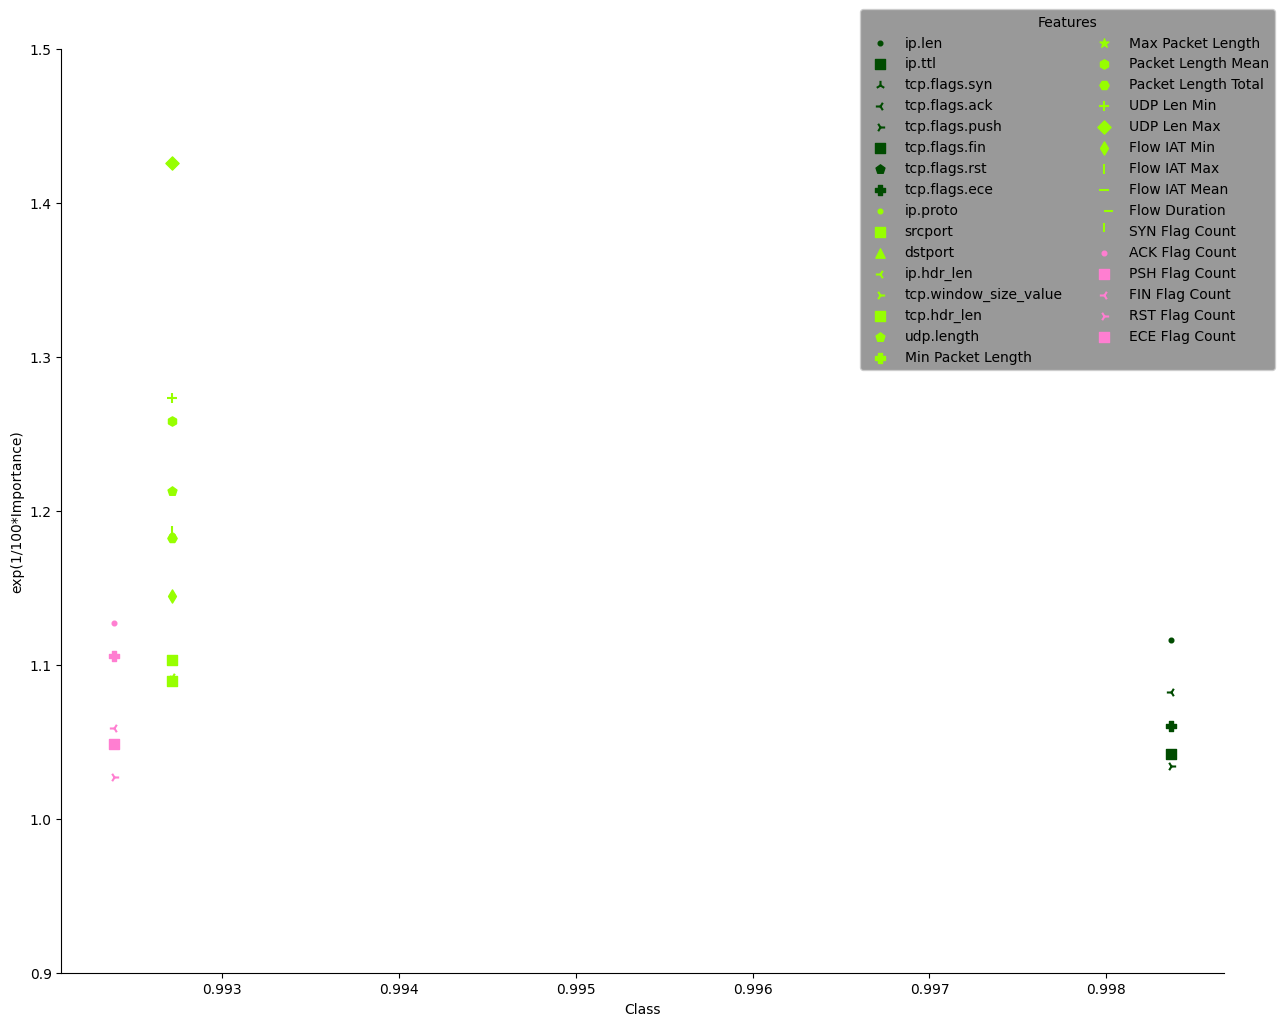

In [235]:
#### CLASS vs IMPORTANCE
## marker: to represent features
marker_lst = [
    ".", ",", "o", "v", "^", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", "*", "h", "H", "+", "x", "X",
    "D", "d", "|", "_", 0, 1, 2, 3, 4, 5
]
## color: to represent classes
color_lst = sns.color_palette(cc.glasbey, n_colors=26)
color_marker_lst = [(c,m) for m in marker_lst for c in color_lst]
#
feature_names = feature_names
class_names = classes_ordered
len_class_names = len(class_names)
#
fig, ax = plt.subplots(figsize=(15,12))
# for j in np.arange(len(feature_names)):
#     ax.scatter(density_df[density_df['f_name']==feature_names[j]]['x_scores'].to_list(),
#                density_df[density_df['f_name']==feature_names[j]]['exp_values'].to_list(), color=color_lst, marker=marker_lst[j],
#                s=25, label=feature_names[j])
    # if j==15:
    #     break
for c in classes_ordered[:3]:
    for j in np.arange(len(feature_names)):
        data_row = cluster_data[(cluster_data['c_name'] == c) & (cluster_data['f_name'] == feature_names[j])]
        try:
            ax.scatter(data_row['x_scores'].to_list()[0], data_row['exp_values'].to_list()[0], color=color_lst[classes.index(c)], marker=marker_lst[j],
                    s=45)
        except:
            continue
    # break
    
## plot feature importance threshold
# ax.hlines(y=25, xmin=-0, xmax=100, colors='k', linestyles='dashed', lw=1)
ax.legend(feature_names, bbox_to_anchor=(1.05, 1.05), title='Features', ncol=2, facecolor='gray')
# ax.set_xticks(Class_2cores_ordered)
# ax.set_xticklabels(feature_names, rotation=90, fontsize = 10)
ax.set_xlabel('Class')
ax.set_ylabel('exp(1/100*Importance)')
ax.set_ylim(bottom=0)
ax.set_ylim(0.9, 1.5)
# ax.set_xlim(0.96, 1)
sns.despine(fig=fig)
#fig.savefig(fig_path+'/feature_importance_distribution_in_classes.pdf', bbox_inches='tight')
plt.show()
plt.close()


In [236]:
cluster_data = cluster_data[cluster_data['x_scores'] > 0.99]

In [237]:
for f_ind in range(0,len(feats_all)):
    cluster_data[feature_names[f_ind]] = np.where(cluster_data['Feature'] == f_ind, 1, 0)

In [238]:
cluster_data = cluster_data.reset_index(drop=True)

In [239]:
X = cluster_data.drop(['c_name', 'f_name', 'Feature'], axis=1)

In [240]:
# copy the data 
X_scaled = X.copy() 
  
# apply normalization techniques on Column 1 
column = 'exp_values'
X_scaled[column] = X_scaled[column]/X_scaled[column].abs().max() 
  
# view normalized data 
# display(X_scaled) 

In [252]:
def get_distance_matrix(X, cluster_data):
    #### Weighted Euclidean Distance
    distance_values = []
    weights = []
    euc_distances = []
    # The first point
    for point1_ind in range(0, len(cluster_data)):
        dist_array = []
        Point_1 = X.iloc[point1_ind].to_numpy()
        Feat_1 = cluster_data.iloc[point1_ind]['f_name']
        Class_1 = cluster_data.iloc[point1_ind]['c_name']
        # Get the Transformed Importance value of Point_1 and Find the closest X points in terms of Transformed Importance (same class)
        tr_importance_1 = cluster_data.iloc[point1_ind]['exp_values']
        df_Point_1 = cluster_data[cluster_data['c_name'] == Class_1]
        df_Point_1['difference'] = abs(df_Point_1['exp_values'] - tr_importance_1)
        closest_points_1 = df_Point_1.sort_values(by='difference')[1:5]['f_name'].to_list()
        #
        # The second point
        for point2_ind in range(0, len(cluster_data)):
            Point_2 = X.iloc[point2_ind].to_numpy()
            Feat_2 = cluster_data.iloc[point2_ind]['f_name']
            Class_2 = cluster_data.iloc[point2_ind]['c_name']
            # Get the Transformed Importance value of Point_2 and Find the closest X points in terms of Transformed Importance (same class)
            tr_importance_2 = cluster_data.iloc[point2_ind]['exp_values']
            df_Point_2 = cluster_data[cluster_data['c_name'] == Class_2]
            df_Point_2['difference'] = abs(df_Point_2['exp_values'] - tr_importance_2)
            closest_points_2 = df_Point_2.sort_values(by='difference')[1:5]['f_name'].to_list()
            # Find the difference between the closest points of Point_1 and Point_2
            different_points = list(set(closest_points_1).symmetric_difference(set(closest_points_2)))
            #
            ## The DISTANCE between 2 points (EUC)
            euc_distance = math.dist(Point_1, Point_2)
            euc_distances.append(euc_distance)
            ##
            ### Distance weighted by the distance of un-common features(points)
            if Feat_1 in different_points:
                different_points.remove(Feat_1)
            if Feat_2 in different_points:   
                different_points.remove(Feat_2)
            distances_between_neighbors = []
            ## Difference between the same feats in different Class
            # print(different_points)
            for d_feat in different_points:
                try:
                    p1= X.iloc[cluster_data[(cluster_data['c_name'] == Class_1) & (cluster_data['f_name'] == d_feat)].index.to_list()[0]].to_numpy() ## FC1
                    p2 = X.iloc[cluster_data[(cluster_data['c_name'] == Class_2) & (cluster_data['f_name'] == d_feat)].index.to_list()[0]].to_numpy() ## FC2
                    # if Class_1 == 'Smart Things' and Class_2 == 'Light Bulbs LiFX Smart Bulb' and Feat_1 == 'ip.ttl' and Feat_2 == 'ip.ttl':
                    #     print(p1)
                    #     print(p2)
                    distances_between_neighbors.append(math.dist(p1,p2))
                except:
                    distances_between_neighbors.append(10)

            if Class_1 == Class_2:                         #C1==C2
                weight = len(different_points) 
                dist_array.append(euc_distance*weight)
            else:                                           #C1!=C2
                weight = sum(distances_between_neighbors)
                dist_array.append(euc_distance+weight)
            

        distance_values.append(dist_array)
    print(max(euc_distances))
    return distance_values
# distance_values

In [253]:
distance_values = get_distance_matrix(X_scaled, cluster_data)

1.5502870902658947


In [254]:
# Initialize the Agglomerative clustering model
model_average = AgglomerativeClustering(n_clusters=4, linkage='average', affinity='precomputed')
#
clusters_average = model_average.fit_predict(distance_values)
#
cluster_data['AGGLOMERATIVE'] = clusters_average
clusters_average

array([3, 3, 2, 3, 3, 2, 2, 3, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 3, 3, 3, 3, 3, 3])

In [255]:
# apply normalization techniques on Column 1 
column = 'exp_values'
cluster_data[column] = cluster_data[column]/cluster_data[column].abs().max() 

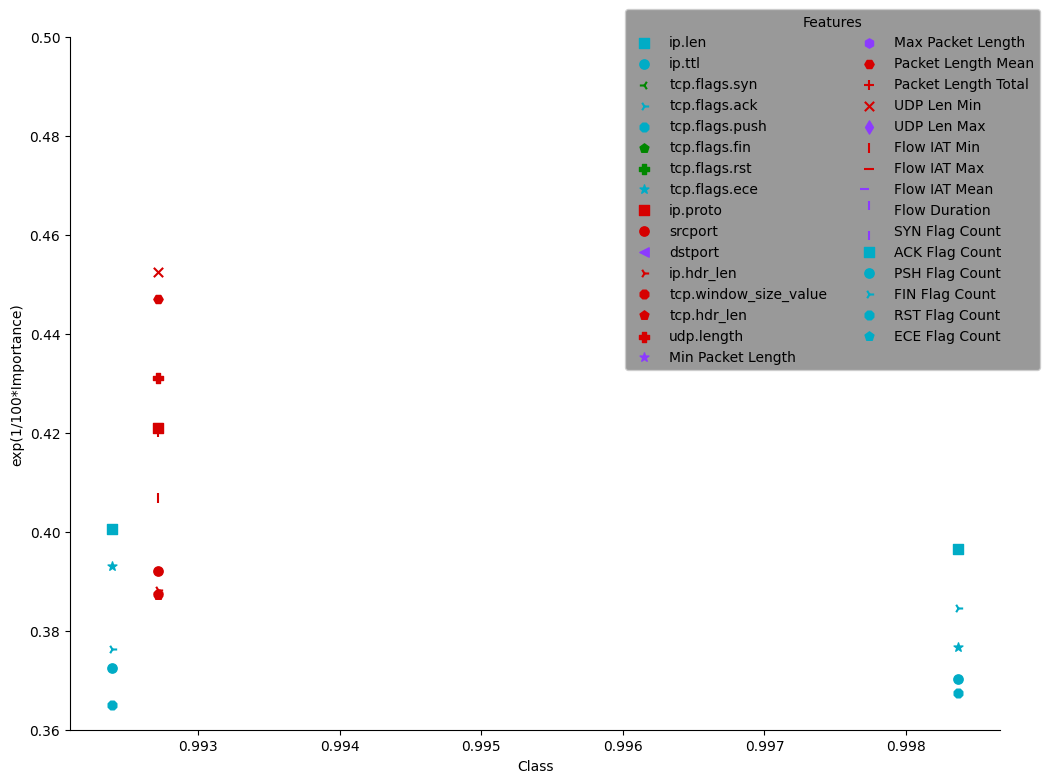

In [256]:
plot_cluster_result('AGGLOMERATIVE', classes_ordered[:3], feature_names, cluster_data, 'x_scores', 'exp_values')